In [1]:
# Set OpenMP environment variables early to avoid libiomp conflicts
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")

import numpy as np
import pandas as pd
import sympy as sy

# Try importing torch, but don't fail if it's not available
try:
    import torch
    TORCH_AVAILABLE = True
    print(f"PyTorch {torch.__version__} is available")
except ImportError:
    TORCH_AVAILABLE = False
    print("Warning: PyTorch is not installed. Using numpy/scipy for diagonalization.")
    torch = None

import ujson as uj

from copy import deepcopy
from functools import partial
from pathlib import Path

from sympy.physics.wigner import wigner_3j, wigner_6j
from numpy import linalg as LA
from IPython.display import Latex, display
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns

from scipy.optimize import least_squares
from scipy.stats import norm

import Energy_Levels_old as EL
from Energy_Levels_old import MoleculeLevels
from Energy_Levels_old import (
    branching_ratios,
    Calculate_TDMs,
    Calculate_TDM_evecs,
    Calculate_forbidden_TDM_evecs,
    Calculate_forbidden_TDMs,
)

print("All imports successful!")

# sns.set()
# sns.set_palette('bright')
# np.set_printoptions(precision=9, suppress=True)
# from tabulate import tabulate

PyTorch 2.5.1+cu121 is available
All imports successful!


In [2]:
# Torch device configuration and GPU-ready diagonalization hooks
# Only configure torch if it's available. Probe CUDA in a short subprocess
# and default to CPU if the probe fails to avoid kernel/driver crashes.
import subprocess, sys, time

if TORCH_AVAILABLE:
    try:
        # Default to CPU; enable CUDA only if a quick safe probe succeeds.
        TORCH_DEVICE = torch.device("cpu")
        cuda_ok = False
        if torch.cuda.is_available():
            probe_code = (
                "import torch, sys\n"
                "try:\n"
                "    x = torch.tensor([1.0], dtype=torch.float32).to('cuda')\n"
                "    torch.cuda.synchronize()\n"
                "    print('cuda_ok')\n"
                "except Exception as e:\n"
                "    print('cuda_fail', e)\n"
                "    sys.exit(1)\n"
            )
            try:
                res = subprocess.run([sys.executable, "-c", probe_code], capture_output=True, text=True, timeout=10)
                if res.returncode == 0 and "cuda_ok" in res.stdout:
                    TORCH_DEVICE = torch.device("cuda")
                    cuda_ok = True
                else:
                    print("CUDA probe failed; output:", res.stdout, res.stderr)
            except Exception as e:
                print("CUDA probe subprocess error:", e)

        print(f"Using torch device: {TORCH_DEVICE} (cuda_ok={cuda_ok})")
    except Exception as e:
        print(f"Warning: Could not configure torch device: {e}")
        TORCH_AVAILABLE = False
        TORCH_DEVICE = torch.device("cpu")
else:
    TORCH_DEVICE = None
    print("Torch not available, using numpy/scipy for diagonalization")

# Store original functions
if not hasattr(EL, "diagonalize_cpu"):
    EL.diagonalize_cpu = EL.diagonalize
    EL.diagonalize_batch_cpu = EL.diagonalize_batch

# ---- GPU profiling statistics ----
GPU_PROFILING = {
    "diagonalize_calls": 0,
    "diagonalize_cuda_calls": 0,
    "diagonalize_cpu_calls": 0,
    "diagonalize_batch_calls": 0,
    "diagonalize_batch_cuda_calls": 0,
    "diagonalize_batch_cpu_calls": 0,
    "total_time_cuda": 0.0,
    "total_time_cpu": 0.0,
    "total_time_batch_cuda": 0.0,
    "total_time_batch_cpu": 0.0,
}

def print_gpu_profile():
    """Print GPU profiling summary."""
    print("\n" + "="*70)
    print("GPU PROFILING SUMMARY")
    print("="*70)
    print(f"Single diagonalize() calls: {GPU_PROFILING['diagonalize_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_cuda_calls']} (total time: {GPU_PROFILING['total_time_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_cpu_calls']} (total time: {GPU_PROFILING['total_time_cpu']:.4f}s)")
    print(f"\nBatch diagonalize_batch() calls: {GPU_PROFILING['diagonalize_batch_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_batch_cuda_calls']} (total time: {GPU_PROFILING['total_time_batch_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_batch_cpu_calls']} (total time: {GPU_PROFILING['total_time_batch_cpu']:.4f}s)")
    if GPU_PROFILING['diagonalize_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_cpu_calls'] > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / GPU_PROFILING['diagonalize_cuda_calls']
        avg_cpu = GPU_PROFILING['total_time_cpu'] / GPU_PROFILING['diagonalize_cpu_calls']
        speedup = avg_cpu / avg_cuda if avg_cuda > 0 else 1.0
        print(f"\nSpeedup (single): {speedup:.2f}x (CUDA avg: {avg_cuda:.6f}s, CPU avg: {avg_cpu:.6f}s)")
    if GPU_PROFILING['diagonalize_batch_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_batch_cpu_calls'] > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / GPU_PROFILING['diagonalize_batch_cuda_calls']
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / GPU_PROFILING['diagonalize_batch_cpu_calls']
        speedup_b = avg_cpu_b / avg_cuda_b if avg_cuda_b > 0 else 1.0
        print(f"Speedup (batch): {speedup_b:.2f}x (CUDA avg: {avg_cuda_b:.6f}s, CPU avg: {avg_cpu_b:.6f}s)")
    print("="*70 + "\n")

# Patch the diagonalize function in the Energy_Levels module
# This ensures internal calls to diagonalize() use our patched version
def diagonalize_with_device(matrix, method="torch", order=False, Normalize=False, round=10):
    """GPU/CPU-aware diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_cuda_calls"] += 1
                # Some CUDA builds/drivers crash on float64 eigh; use float32 on device for stability
                tensor = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensor)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().astype(np.float64).T, round)
            else:
                GPU_PROFILING["diagonalize_cpu_calls"] += 1
                tensor = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensor)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().T, round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_cpu"] += elapsed
                
            if order:
                idx_order = np.argsort(evals)
                evecs = evecs[idx_order, :]
                evals = evals[idx_order]
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_cpu(matrix, method=method, order=order, Normalize=Normalize, round=round)


def diagonalize_batch_with_device(matrix_array, method="torch", round=10):
    """GPU/CPU-aware batch diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_batch_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix_array)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_batch_cuda_calls"] += 1
                tensors = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensors)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1).astype(np.float64), round)
            else:
                GPU_PROFILING["diagonalize_batch_cpu_calls"] += 1
                tensors = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensors)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1), round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_batch_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_batch_cpu"] += elapsed
                
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch batch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_batch_cpu(matrix_array, method=method, round=round)


# Patch the functions in the module namespace
# This replaces the function references so internal calls use the patched version
EL.diagonalize = diagonalize_with_device
EL.diagonalize_batch = diagonalize_batch_with_device
if TORCH_AVAILABLE:
    EL.TORCH_DEVICE = TORCH_DEVICE

print("Diagonalization functions configured successfully.")
print(f"Default method: {'torch (GPU-accelerated)' if (TORCH_AVAILABLE and TORCH_DEVICE.type == 'cuda') else 'torch (CPU)' if TORCH_AVAILABLE else 'numpy'}")

Using torch device: cuda (cuda_ok=True)
Diagonalization functions configured successfully.
Default method: torch (GPU-accelerated)


In [3]:
import Energy_Levels_old as EL, torch
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))
print("EL.diagonalize:", EL.diagonalize.__name__)

EL.TORCH_DEVICE: cuda
EL.diagonalize: diagonalize_with_device


In [4]:
# Python
import torch, Energy_Levels_old as EL, time
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda runtime version:", torch.version.cuda)
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))

torch: 2.5.1+cu121
cuda available: True
cuda runtime version: 12.1
device count: 1
device name: NVIDIA RTX A2000
EL.TORCH_DEVICE: cuda


In [5]:
X010_173 = MoleculeLevels.initialize_state(
    "YbOH",
    "173",
    "X010",
    [1, 2],
    M_values="all",
    I=[5 / 2, 1 / 2],
    S=1 / 2,
    round=8,
    P_values=[1 / 2, 3 / 2],
)

BASE_PARAMETERS = deepcopy(X010_173.parameters)
FIT_PARAMETER_NAMES = [
    "Be",
    "Gamma_SR",
    "Gamma_Prime",
    "bFYb",
    "cYb",
    "bFH",
    "cH",
    "e2Qq0",
    "q_lD",
    "p_lD",
    "muE",
    "g_S_eff",
]
PARAM_PRIORS = {key: BASE_PARAMETERS[key] for key in FIT_PARAMETER_NAMES}


def _default_bound(value, frac=0.2, floor=1e-6):
    span = max(abs(value) * frac, floor)
    return value - span, value + span


FIT_PARAMETER_BOUNDS = {key: _default_bound(PARAM_PRIORS[key]) for key in FIT_PARAMETER_NAMES}

print(f"Loaded {X010_173.iso_state} with {len(FIT_PARAMETER_NAMES)} fit parameters tracked.")

Loaded 173X010 with 12 fit parameters tracked.


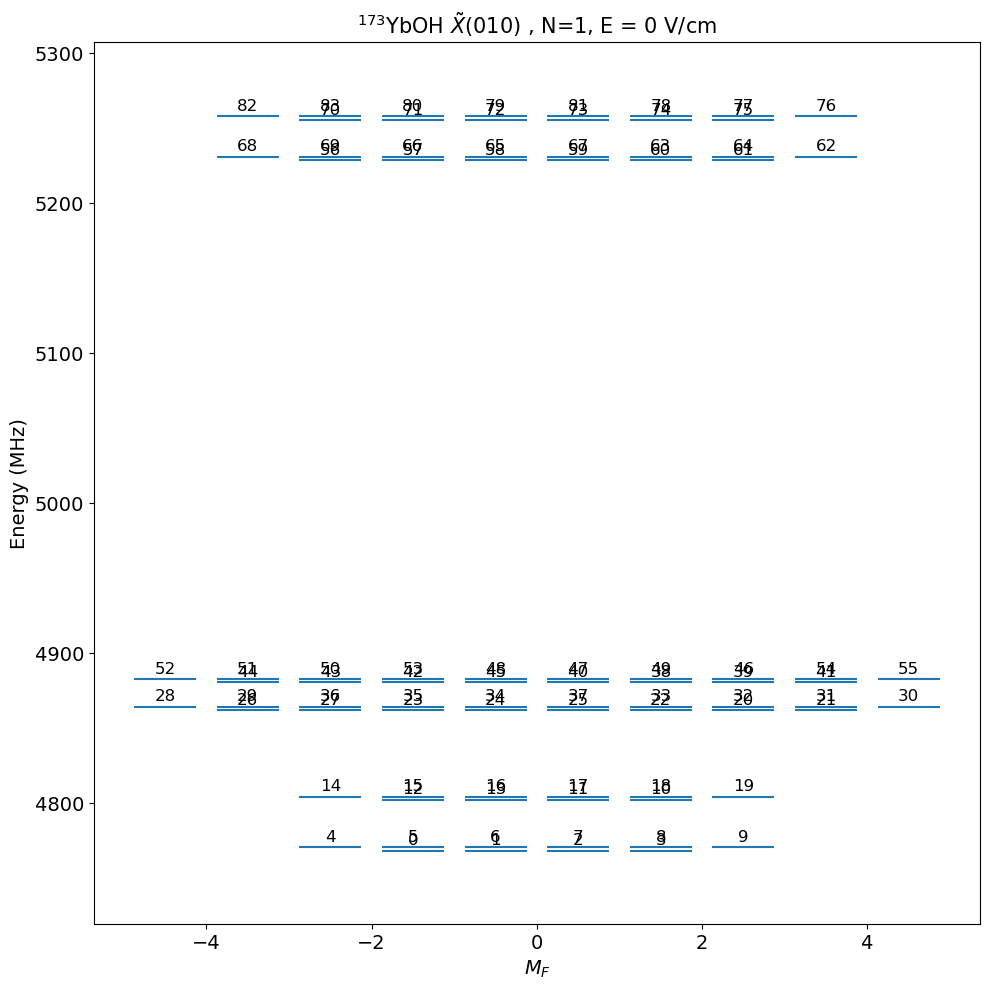

In [6]:
Efield = 0
X010_173.display_PTV(Efield,1e-8,'all',step_B = 1e-4, step_E = 1e-2, idx = X010_173.select_q({'N':1,'G':3}),round=4,figsize=(10,10),off = 0, scale2 = 1.2, plot_state_index = True, plot_CPV = False, plot_only_one_CPV = None, fontsize_for_values = 12)
plt.title(X010_173.state_str + ' , N=1, E = {} V/cm'.format(X010_173.E0),fontsize=15)
#plt.yticks(np.linspace(4700,5300,301))
#plt.ylim(10800,10900)
plt.tight_layout()
plt.show()
#plt.savefig('MQM_science_state_level_diagram_20230313_173_all_shifts_' + str(Efield) + 'Vcm.pdf')

In [6]:
def set_state_parameters(state, updates=None):
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)

    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params

    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers,
        params=new_params,
        M_values=state.M_values,
        precision=state.round,
    )

    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)



def parameter_vector_to_dict(vector):
    return {name: value for name, value in zip(FIT_PARAMETER_NAMES, vector)}


def current_parameter_dict(state=None):
    source = state.parameters if state is not None else BASE_PARAMETERS
    return {name: source[name] for name in FIT_PARAMETER_NAMES}


def parameters_to_vector(params):
    return np.array([params[name] for name in FIT_PARAMETER_NAMES], dtype=float)

set_state_parameters(X010_173)
baseline_parameter_vector = parameters_to_vector(current_parameter_dict(X010_173))

In [7]:

# Frequency transform controls (matching the previous plotting convention)
FREQ_OFFSET = 0  # MHz
FREQ_SCALE = 1  # Divide by two for two-photon frequency conversion
FREQ_SHIFT = 0  # Additional shift applied after scaling


def model_frequency_transform(raw_freq):
    """Map raw transition frequency from the model to the experimental frequency axis."""
    return (raw_freq - FREQ_OFFSET) * FREQ_SCALE + FREQ_SHIFT


# indices 38–55 and 70–83 (inclusive)
#TRANSITION_INDEX_SET = list(range(10, 19)) + list(range(38, 56)) + list(range(70, 84)) + list(range(90, 95)) + list(range(110, 123)) + list(range(134, 143))
TRANSITION_INDEX_SET = list(range(10, 19)) + list(range(38, 56)) + list(range(70, 84)) 
print(TRANSITION_INDEX_SET)
LASER_POLARIZATION = "both"
PARITY_SIGN = 1
INTENSITY_THRESHOLD = None  # Set to a float to discard transitions with weaker intensity
EZ_FIELD = 0  # Update if the experimental conditions change
B_FIELD = 1e-8

[10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


In [8]:
def compute_model_transitions(
    state,
    Ez=EZ_FIELD,
    B=B_FIELD,
    indices=None,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=None,
):
    """
    Compute model transitions with optional state index filtering.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None, optional
        Filter transitions to specific state index pairs.
        Format: [((lower_min, lower_max), (upper_min, upper_max)), ...]
        Example: [((46, 55), (76, 83)), ((38, 45), (70, 75))]
    """
    index_list = indices if indices is not None else TRANSITION_INDEX_SET
    if index_list is None:
        index_list = list(range(84))

    result = state.calculate_two_photon_spectrum(
        Ez,
        B,
        index_list,
        parity_sign=parity_sign,
        laser_polarization=polarization,
        allowed_transitions=allowed_transitions,
    )
    transitions = pd.DataFrame(result[1])

    if not transitions.empty:
        transitions["freq_model"] = transitions["freq"].apply(model_frequency_transform)
        if INTENSITY_THRESHOLD is not None:
            intensity_key = next(
                (key for key in ["intensity", "Intensity", "strength"] if key in transitions.columns),
                None,
            )
            if intensity_key is not None:
                transitions = transitions[transitions[intensity_key] >= INTENSITY_THRESHOLD].reset_index(drop=True)

    return transitions, result


def merge_predictions_with_experiment(predicted_df, experimental_df):
    if experimental_df.empty:
        predicted_df = predicted_df.copy()
        predicted_df["freq_obs"] = np.nan
        predicted_df["residual"] = np.nan
        predicted_df["weight"] = 1.0
        return predicted_df, pd.DataFrame(), predicted_df

    merge_cols = ["state index 0", "state index 1"]
    for col in ["M0", "M1"]:
        if col in experimental_df.columns and col in predicted_df.columns:
            merge_cols.append(col)

    merged = experimental_df.merge(predicted_df, how="left", on=merge_cols, suffixes=("_obs", "_model"))
    missing = merged[merged["freq_model"].isna()].copy()

    merged["freq_model"] = merged["freq_model"].astype(float)
    merged["residual"] = merged["freq_model"] - merged["freq_obs"]
    if "uncertainty" in merged.columns:
        weights = merged["uncertainty"].replace(0, np.nan).fillna(1.0)
    else:
        weights = pd.Series(1.0, index=merged.index)
    merged["weight"] = weights
    merged["weighted_residual"] = merged["residual"] / merged["weight"]

    matched = merged[merged["freq_model"].notna()].copy()
    return matched, missing, predicted_df


def summarize_fit(matched_df):
    if matched_df.empty:
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    valid = np.isfinite(matched_df["residual"]) & np.isfinite(matched_df["weight"])
    if not valid.any():
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    residuals = matched_df.loc[valid, "residual"].to_numpy()
    weights = matched_df.loc[valid, "weight"].to_numpy()
    rms = np.sqrt(np.mean(residuals**2))
    weighted_rms = np.sqrt(np.mean((residuals / weights) ** 2))
    return {"rms": rms, "weighted_rms": weighted_rms, "n_points": int(valid.sum())}

In [9]:
uncertainty_factor = 1


import importlib.util
from pathlib import Path

# ---------------------------
# Load molecule_parameters.py
# ---------------------------
MP_PATH = Path("molecule_parameters.py")  # if it's in the notebook folder
if not MP_PATH.exists():
    # if needed, point to your uploaded path or repo path:
    MP_PATH = Path("/mnt/data/molecule_parameters.py")

spec = importlib.util.spec_from_file_location("molecule_parameters", str(MP_PATH))
mp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mp)

# ---------------------------------------------------------
# Read the parameter MEANS for YbOH 173X010 (includes general)
# ---------------------------------------------------------
# This is the clean merged dict that your library likely expects:
params_173X010_mean = dict(mp.all_params["YbOH"]["173X010"])  # includes params_general
# alternatively: params_173X010_mean = {**mp.params_173X010, **mp.params_general}

# (Optional) apply these as the baseline parameters to your state
# Use only keys your state actually supports, to avoid KeyError downstream.
state_supported = set(current_parameter_dict(X010_173).keys())
params_173X010_mean_filtered = {k: v for k, v in params_173X010_mean.items() if k in state_supported}

set_state_parameters(X010_173, params_173X010_mean_filtered)

print("Loaded params for 173X010 (filtered to state):")
for k in sorted(params_173X010_mean_filtered.keys()):
    print(f"  {k:12s} = {params_173X010_mean_filtered[k]}")

# ---------------------------------------------------------
# Define / build UNCERTAINTIES (sigmas) -> you must supply these
# ---------------------------------------------------------
# Recommended: make a dict with 1-sigma uncertainties in the SAME UNITS as params.
# If you don't have them yet, start with fractional placeholders.
PARAM_SIGMA_173X010 = {
    # Fill these with your measured 1-sigma uncertainties (MHz etc.)
    # Examples (PLACEHOLDERS — replace with real numbers):
    "Be": 0.4*uncertainty_factor,
    "Gamma_SR": 3*uncertainty_factor,
    "Gamma_Prime": 4*uncertainty_factor,
    "bFYb": 0.8*uncertainty_factor,
    "cYb": 10*uncertainty_factor,
    "e2Qq0": 27*uncertainty_factor,
    "q_lD": 0.5*uncertainty_factor,
    "p_lD": 5*uncertainty_factor,
    "muE": 0.01 * 0.503412 *uncertainty_factor, 
    "g_S_eff": 0.02*uncertainty_factor,
}

# Fractional fallback if sigma not provided:
FRACTIONAL_SIGMA_FALLBACK = {
    "Be": 1e-4,
    "Gamma_SR": 2e-2,
    "Gamma_Prime": 2e-2,
    "bFYb": 5e-3,
    "cYb": 5e-2,
    "e2Qq0": 1e-2,
    "q_lD": 5e-2,
    "p_lD": 5e-2,
    "muE": 5e-3,
    "g_S_eff": 5e-3,
}

# Build priors: PARAM_PRIORS[name] = (mean, sigma)
PARAM_PRIORS = {}
for k, mu in params_173X010_mean_filtered.items():
    if k in PARAM_SIGMA_173X010:
        sig = float(PARAM_SIGMA_173X010[k])
    else:
        frac = float(FRACTIONAL_SIGMA_FALLBACK.get(k, 0.05))  # default 5% if unknown
        sig = abs(float(mu)) * frac if float(mu) != 0 else frac
    if sig <= 0:
        continue
    PARAM_PRIORS[k] = (float(mu), float(sig))

print("\nBuilt PARAM_PRIORS (mean, sigma):")
for k in sorted(PARAM_PRIORS.keys()):
    mu, sig = PARAM_PRIORS[k]
    print(f"  {k:12s} : mu={mu:.6g}, sigma={sig:.6g}")


Loaded params for 173X010 (filtered to state):
  Be           = 7334.130786908366
  Gamma_Prime  = 14.233846113382
  Gamma_SR     = -87.18714159785
  bFH          = 4.07
  bFYb         = -1880.9665339648823
  cH           = 5.49
  cYb          = -92.159499306238
  e2Qq0        = -3154.2
  g_S_eff      = 2.07
  muE          = 1.08736992
  p_lD         = 12.766362031472
  q_lD         = 12.494150479608

Built PARAM_PRIORS (mean, sigma):
  Be           : mu=7334.13, sigma=0.4
  Gamma_Prime  : mu=14.2338, sigma=4
  Gamma_SR     : mu=-87.1871, sigma=3
  bFH          : mu=4.07, sigma=0.2035
  bFYb         : mu=-1880.97, sigma=0.8
  cH           : mu=5.49, sigma=0.2745
  cYb          : mu=-92.1595, sigma=10
  e2Qq0        : mu=-3154.2, sigma=27
  g_S_eff      : mu=2.07, sigma=0.02
  muE          : mu=1.08737, sigma=0.00503412
  p_lD         : mu=12.7664, sigma=5
  q_lD         : mu=12.4942, sigma=0.5


In [10]:
import numpy as np
import pandas as pd
from pathlib import Path


# -----------------------------
# Unassigned multi-spectrum data loading
# -----------------------------
UNASSIGNED_DATA_PATH = Path("synthetic_peaks.csv")  # or your real CSV
UNASSIGNED_SIGMA = 0.05  # MHz Gaussian broadening (100 kHz) used in loss and plotting

# Fallback defaults ONLY used if you call the model without Ez/B explicitly
DEFAULT_EZ_FIELD = 0.0
DEFAULT_B_FIELD = 1e-8

# Load peak-list data (must contain these columns)
dfu = pd.read_csv(UNASSIGNED_DATA_PATH)
required = ["spectrum_id", "Ez_V_per_cm", "Bz_G", "nu_obs_MHz"]
missing = [c for c in required if c not in dfu.columns]
if missing:
    raise ValueError(f"Unassigned spectrum CSV missing columns: {missing}")

dfu["nu_obs_MHz"] = pd.to_numeric(dfu["nu_obs_MHz"], errors="coerce")
dfu = dfu.dropna(subset=["nu_obs_MHz"]).reset_index(drop=True)

OBS_SPECTRA = []
for sid, g in dfu.groupby("spectrum_id", sort=False):
    Ez = float(g["Ez_V_per_cm"].iloc[0])
    Bz = float(g["Bz_G"].iloc[0])
    freqs = np.sort(g["nu_obs_MHz"].to_numpy(dtype=float))
    OBS_SPECTRA.append({"id": sid, "Ez": Ez, "B": Bz, "freqs": freqs})

print("Loaded spectra:", [(s["id"], len(s["freqs"]), s["Ez"], s["B"]) for s in OBS_SPECTRA])


# -----------------------------
# Unassigned spectrum comparison machinery
# -----------------------------
def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA, axis=None, **kwargs):
    """Gaussian broadening that accepts either freq_axis= or axis= (or positional axis).

    This is defensive so later callers passing freq_axis won't break if an older
    signature (freqs, weights, axis, sigma) was in scope.
    """
    frequencies = np.asarray(frequencies, float)
    if weights is None:
        weights = np.ones_like(frequencies)
    else:
        weights = np.asarray(weights, float)

    # Accept either freq_axis or axis (keyword or positional via kwargs.get)
    if freq_axis is None:
        freq_axis = axis if axis is not None else kwargs.pop("axis", None)

    if freq_axis is None:
        if frequencies.size == 0:
            return np.linspace(0, 1, 1000), np.zeros(1000)
        f_min = frequencies.min() - 3 * sigma
        f_max = frequencies.max() + 3 * sigma
        freq_axis = np.linspace(f_min, f_max, 2000)

    if frequencies.size == 0:
        return freq_axis, np.zeros_like(freq_axis)

    diff = freq_axis[:, None] - frequencies[None, :]
    spec = np.exp(-(diff**2) / (2 * sigma**2)) @ weights
    return freq_axis, spec


def spectral_residual(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA):
    """
    Compare two unassigned peak lists by converting each into a Gaussian-broadened "spectrum"
    on a shared frequency axis and computing RMS difference.
    
    MODIFIED: Now computes UNNORMALIZED RMS to preserve absolute spectral position information.
    This means the loss function will penalize frequency shifts, not just shape mismatches.
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)

    # Choose a shared axis covering both
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    if predicted_freqs.size == 0:
        fmin, fmax = observed_freqs.min(), observed_freqs.max()
    elif observed_freqs.size == 0:
        fmin, fmax = predicted_freqs.min(), predicted_freqs.max()
    else:
        fmin = min(predicted_freqs.min(), observed_freqs.min())
        fmax = max(predicted_freqs.max(), observed_freqs.max())

    axis = np.linspace(fmin - 3*sigma, fmax + 3*sigma, 2000)

    _, pred_spec = gaussian_broadened_spectrum(predicted_freqs, weights=predicted_weights, freq_axis=axis, sigma=sigma)
    _, obs_spec  = gaussian_broadened_spectrum(observed_freqs,  weights=observed_weights,  freq_axis=axis, sigma=sigma)

    # MODIFIED: Keep spectra UNNORMALIZED to preserve absolute position information
    # This way, if peaks are shifted in frequency, the loss will be higher
    # We still normalize by the max of observed spectrum to keep loss scale reasonable
    norm_factor = obs_spec.max() if obs_spec.max() > 0 else 1.0
    pred_spec = pred_spec / norm_factor
    obs_spec  = obs_spec  / norm_factor

    return float(np.sqrt(np.mean((pred_spec - obs_spec)**2)))


def spectral_residual_absolute_position(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA, enforce_observed_coverage=True, match_tolerance=0.5):
    """
    Loss function that optimizes for absolute spectral position overlap.
    
    CONSTRAINT: All observed peaks MUST have a corresponding predicted peak nearby.
    
    Parameters:
    -----------
    predicted_freqs : array
        Predicted transition frequencies
    observed_freqs : array
        Observed peak frequencies
    enforce_observed_coverage : bool (default=True)
        If True: HEAVILY penalizes any observed peak without a nearby predicted peak
        If False: Uses bidirectional distance (old behavior)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched"
        
    Loss components:
    1. PRIMARY (if enforce_observed_coverage=True): 
       - For each observed peak, find nearest predicted peak
       - Penalize: distance to match + penalty if no match within tolerance
    2. SECONDARY:
       - Penalty for each unmatched predicted peak (but allows extra predictions)
    3. OVERALL:
       - Encourages all observed peaks to be covered by predictions
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)
    
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    
    # HARD CONSTRAINT: If no predicted peaks, heavy penalty
    if predicted_freqs.size == 0:
        return 100.0 + len(observed_freqs) * 10.0
    
    # If no observed peaks, no loss (but penalize extra predictions)
    if observed_freqs.size == 0:
        return len(predicted_freqs) * 0.5
    
    # ====== PRIMARY LOSS: Enforce that ALL observed peaks have predicted matches ======
    obs_to_pred_dist = []
    unmatched_count = 0
    
    for obs_freq in observed_freqs:
        min_dist = np.min(np.abs(predicted_freqs - obs_freq))
        obs_to_pred_dist.append(min_dist)
        
        # If this observed peak has no nearby predicted peak, it's unmatched
        if min_dist > match_tolerance:
            unmatched_count += 1
    
    avg_obs_to_pred = np.mean(obs_to_pred_dist)
    
    # HEAVY penalty for unmatched observed peaks (this is the key constraint!)
    unmatched_penalty = unmatched_count * 5.0
    
    # ====== SECONDARY LOSS: Penalize extra predicted peaks (less strongly) ======
    pred_to_obs_dist = []
    unmatched_pred_count = 0
    
    for pred_freq in predicted_freqs:
        min_dist = np.min(np.abs(observed_freqs - pred_freq))
        pred_to_obs_dist.append(min_dist)
        
        # If this predicted peak is far from any observed peak, it's extra
        if min_dist > match_tolerance:
            unmatched_pred_count += 1
    
    avg_pred_to_obs = np.mean(pred_to_obs_dist)
    
    # Lighter penalty for extra predicted peaks (we allow extra predictions)
    extra_pred_penalty = unmatched_pred_count * 0.5
    
    if enforce_observed_coverage:
        # PRIMARY: Force all observed peaks to be matched
        # SECONDARY: Lightly penalize extra predictions
        total_loss = avg_obs_to_pred + unmatched_penalty + extra_pred_penalty
    else:
        # Old behavior: bidirectional matching
        total_loss = avg_obs_to_pred + avg_pred_to_obs
    
    return float(total_loss)


def extract_transition_freqs(state, state_pairs, Ez=None, B=None, indices=None, **kwargs):
    """
    Extract predicted frequencies for transitions between specific state pairs.
    
    Parameters:
    -----------
    state_pairs : list of tuples or tuple
        List of (lower_range, upper_range) tuples specifying allowed transitions
        Each range is (min, max) inclusive.
        Example: [((38, 45), (70, 75))] extracts transitions between states 38-45 and 70-75
    Ez : float
        Electric field (V/cm)
    B : float
        Magnetic field (Gauss)
    
    Returns:
    --------
    freqs : array
        Frequencies of transitions matching the specified state pairs
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD
    
    # Convert single tuple to list
    if isinstance(state_pairs, tuple):
        state_pairs = [state_pairs]
    
    # Remove allowed_transitions from kwargs if present (we're providing our own)
    kwargs.pop('allowed_transitions', None)
    
    # Get transitions with the state pair constraint
    transitions, _ = compute_model_transitions(
        state, Ez=Ez, B=B, indices=indices, 
        allowed_transitions=state_pairs,
        **kwargs
    )
    
    if transitions is None or transitions.empty:
        return np.array([])
    
    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    return freqs


def check_peak_assignment_0V(state, observed_freqs_0V, indices=None, **kwargs):
    """
    Check how well the predicted spectrum at 0 V/cm matches the known peak assignments.
    
    Known assignment at 0 V/cm:
    - Lower frequency peak (left) → states 38-45 ↔ 70-75
    - Higher frequency peak (right) → states 46-55 ↔ 76-83
    
    Parameters:
    -----------
    observed_freqs_0V : array
        Observed peak frequencies at 0 V/cm (should have 2 elements: [lower, higher])
    
    Returns:
    --------
    assignment_loss : float
        Penalty for incorrect assignment (0 = perfect, higher = worse)
    """
    if len(observed_freqs_0V) < 2:
        return 0.0  # Can't check if we don't have 2 peaks
    
    # Sort observed peaks
    obs_lower = min(observed_freqs_0V)
    obs_higher = max(observed_freqs_0V)
    
    # Get predicted freqs for each assignment
    freqs_lower_pair = extract_transition_freqs(
        state, ((38, 45), (70, 75)), Ez=0, B=1e-8, indices=indices, **kwargs
    )
    freqs_higher_pair = extract_transition_freqs(
        state, ((46, 55), (76, 83)), Ez=0, B=1e-8, indices=indices, **kwargs
    )
    
    # Find best match for each observed peak to its expected transition set
    loss = 0.0
    
    # Penalty for lower peak not matching the lower pair
    if len(freqs_lower_pair) > 0:
        min_dist_lower = np.min(np.abs(freqs_lower_pair - obs_lower))
    else:
        min_dist_lower = 5.0  # Heavy penalty if no predictions for this pair
        loss += 10.0
    
    # Penalty for higher peak not matching the higher pair
    if len(freqs_higher_pair) > 0:
        min_dist_higher = np.min(np.abs(freqs_higher_pair - obs_higher))
    else:
        min_dist_higher = 5.0  # Heavy penalty if no predictions for this pair
        loss += 10.0
    
    # Add distance penalties
    loss += min_dist_lower + min_dist_higher
    
    return float(loss)


def transition_frequency_set(state, Ez=None, B=None, indices=None, **kwargs):
    """
    Returns predicted transition frequencies and weights for a given (Ez,B).
    FIX: no default args referencing EZ_FIELD/B_FIELD -> avoids NameError.
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD

    transitions, raw = compute_model_transitions(state, Ez=Ez, B=B, indices=indices, **kwargs)
    if transitions is None or transitions.empty:
        return np.array([]), np.array([]), raw

    # Try to pull an intensity/strength column if present
    weights = None
    for candidate in ["intensity", "Intensity", "strength", "Strength"]:
        if candidate in transitions.columns:
            weights = transitions[candidate].to_numpy(dtype=float)
            break

    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    if weights is None:
        weights = np.ones_like(freqs)

    return freqs, weights, raw


def unassigned_multispectrum_loss(state, spectra, indices=None, sigma=UNASSIGNED_SIGMA, use_absolute_position=True, enforce_observed_coverage=True, match_tolerance=1.0, enforce_0V_assignment=True, assignment_penalty_weight=10.0, **kwargs):
    """
    Average loss over many spectra, each with its own Ez/B.
    
    Parameters:
    -----------
    use_absolute_position : bool (default=True)
        If True, uses spectral_residual_absolute_position which directly optimizes peak positions.
        If False, uses the original spectral_residual with spectral shape comparison.
    enforce_observed_coverage : bool (default=True)
        If True: ALL observed peaks MUST have a nearby predicted peak (this is the constraint!)
        If False: Uses bidirectional matching (predicted peaks must also have observed counterparts)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched" (e.g., 1.0 MHz)
    enforce_0V_assignment : bool (default=True)
        If True: Enforce known peak assignments at 0 V/cm:
            - Lower freq peak ↔ states 38-45 to 70-75
            - Higher freq peak ↔ states 46-55 to 76-83
    assignment_penalty_weight : float (default=2.0)
        Weight factor for assignment penalty relative to main loss
    """
    losses = []
    assignment_losses = []
    
    for s in spectra:
        # Pass only the kwargs that transition_frequency_set needs
        pred_f, pred_w, _ = transition_frequency_set(state, Ez=s["Ez"], B=s["B"], indices=indices, **kwargs)
        
        if use_absolute_position:
            # Use absolute position loss with observed peak coverage constraint
            loss = spectral_residual_absolute_position(
                pred_f, s["freqs"], 
                predicted_weights=pred_w, 
                observed_weights=None, 
                sigma=sigma,
                enforce_observed_coverage=enforce_observed_coverage,
                match_tolerance=match_tolerance
            )
        else:
            # Use original spectral comparison (now with unnormalized spectra)
            loss = spectral_residual(pred_f, s["freqs"], 
                                    predicted_weights=pred_w, 
                                    observed_weights=None, 
                                    sigma=sigma)
        losses.append(loss)
        
        # ====== ADDITIONAL CONSTRAINT: Check 0 V/cm peak assignments ======
        if enforce_0V_assignment and s["Ez"] == 0.0:
            # At 0 V/cm, we know the peak assignments
            assignment_loss = check_peak_assignment_0V(
                state, s["freqs"], indices=indices,
                parity_sign=kwargs.get("parity_sign", PARITY_SIGN),
                polarization=kwargs.get("polarization", LASER_POLARIZATION),
                allowed_transitions=kwargs.get("allowed_transitions", None)
            )
            assignment_losses.append(assignment_loss)

    avg_loss = float(np.mean(losses)) if losses else np.inf
    
    # Add weighted assignment constraint
    if enforce_0V_assignment and assignment_losses:
        avg_assignment_loss = float(np.mean(assignment_losses))
        total_loss = avg_loss + assignment_penalty_weight * avg_assignment_loss
    else:
        total_loss = avg_loss
    
    return total_loss


Loaded spectra: [('spec0', 2, 0.0, 0.0), ('spec10', 4, 10.0, 0.0), ('spec20', 5, 20.0, 0.0), ('spec40', 8, 40.0, 0.0)]


In [11]:
# ============================================================================
# EXPERIMENTAL CONSTRAINTS: Allowed State Index Pairs
# ============================================================================
# Define experimentally-constrained transitions:
# - Transitions between states 46-55 and states 76-83
# - Transitions between states 38-45 and states 70-75

ALLOWED_TRANSITIONS = [
    ((46, 55), (76, 83)),  # First set of allowed transitions
    ((38, 45), (70, 75)),  # Second set of allowed transitions
]

print("Experimental constraints loaded:")
print(f"  - Transitions between states 46-55 ↔ 76-83")
print(f"  - Transitions between states 38-45 ↔ 70-75")
print(f"\nTo use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS")
print(f"to compute_model_transitions() or related functions.")
print(f"\nTo disable filtering (compute all transitions), use allowed_transitions=None")

Experimental constraints loaded:
  - Transitions between states 46-55 ↔ 76-83
  - Transitions between states 38-45 ↔ 70-75

To use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS
to compute_model_transitions() or related functions.

To disable filtering (compute all transitions), use allowed_transitions=None


Current molecular constants:
Be (rotational constant):           7334.100000 MHz
e2Qq0 (quadrupole coupling):        -3153.061000 MHz
Gamma_SR (hyperfine):               -87.187142 MHz
Gamma_Prime (hyperfine):            14.233846 MHz
bFYb (tensor interaction):          -1880.966534 MHz
cYb (tensor interaction):           -92.159499 MHz
q_lD (quad. field dependence):      12.494150 MHz/(V/cm)
p_lD (quad. field dependence):      12.766362 MHz/(V/cm)
muE (E-field sensitivity):          1.101295 MHz/(V/cm)

✓ Parameters applied to X010_173 state object
✓ Ready to run cell 13 to calculate spectrum


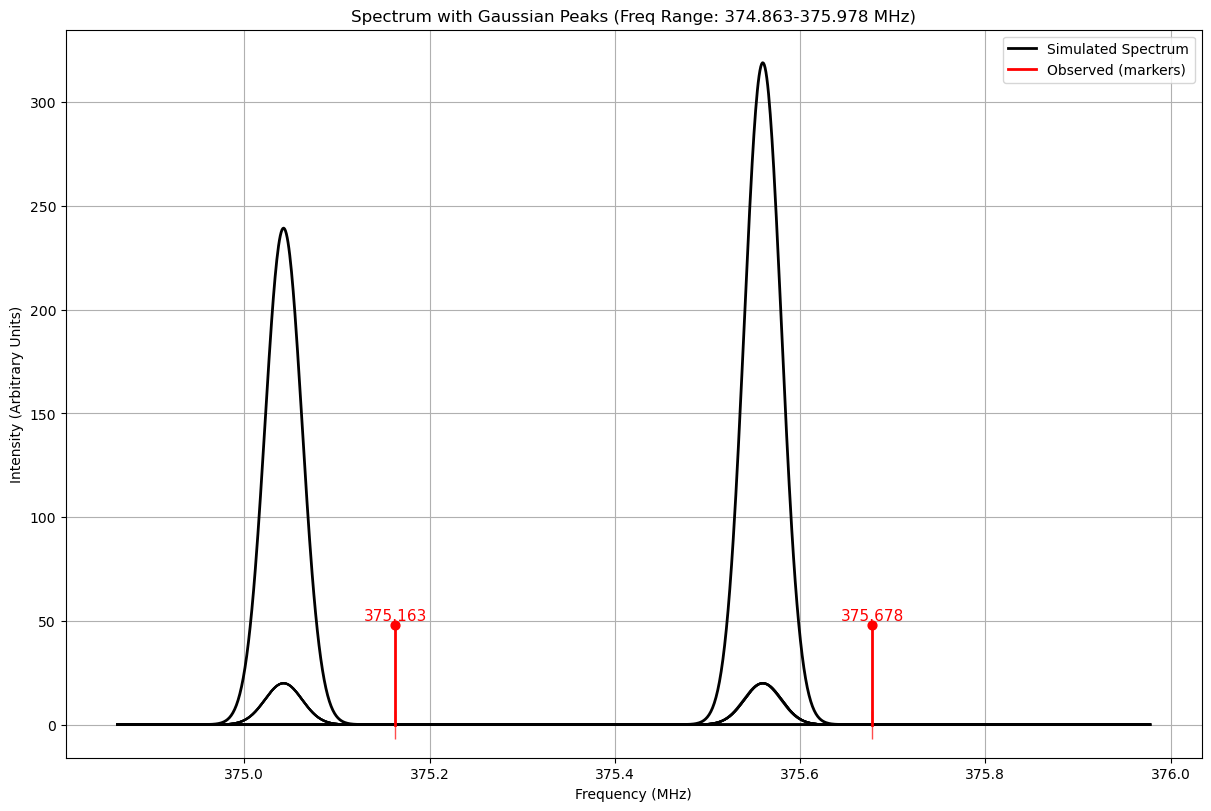

([375.04248047000056, 375.04248047000056, 375.04248047000056, 375.04248047000056, 375.04248047000056, 375.04248047000056, 375.04248047000056, 375.04248047000056, 375.04248047000056, 375.04248047000056, 375.0419921900002, 375.0419921900002, 375.56005860000005, 375.56005860000005, 375.56005860000005, 375.56005860000005, 375.56005860000005, 375.56005860000005, 375.56005860000005, 375.56005860000005, 375.5595703199997, 375.5595703199997, 375.56005860000005, 375.5595703199997, 375.5595703199997, 375.56005860000005, 375.55908203000035, 375.55908203000035], [{'freq': 375.04248047000056, 'state index 0': 38, 'energy 0': 4880.44482422, 'N0': 1.0, 'G0': 3.0, 'F10': 4.0, 'F0': 3.5, 'M0': -1.5, 'Parity0': 1.0000003546377243, 'state index 1': 73, 'energy 1': 5255.48730469, 'N1': 1.0, 'G1': 3.0, 'F11': 3.0, 'F1': 2.5, 'M1': -0.5, 'Parity1': 0.9999998713560426}, {'freq': 375.04248047000056, 'state index 0': 38, 'energy 0': 4880.44482422, 'N0': 1.0, 'G0': 3.0, 'F10': 4.0, 'F0': 3.5, 'M0': -1.5, 'Parit

In [12]:
# ============================================================
# MANUAL PARAMETER SPECIFICATION FOR SPECTRUM CALCULATION
# ============================================================
# Edit the values below to change the molecular constants
# Then run cell 13 to see the two-photon spectrum

# Get current parameters as starting point
manual_params = current_parameter_dict(X010_173)

print("Current molecular constants:")
print("=" * 70)

# ========== ROTATIONAL & QUADRUPOLE ==========
manual_params['Be'] = 7334.1  # Rotational constant (MHz)
manual_params['e2Qq0'] = -3153.061  # Quadrupole coupling (MHz)

print(f"Be (rotational constant):           {manual_params['Be']:.6f} MHz")
print(f"e2Qq0 (quadrupole coupling):        {manual_params['e2Qq0']:.6f} MHz")

# ========== HYPERFINE ==========
manual_params['Gamma_SR'] = -87.187142
manual_params['Gamma_Prime'] = 14.233846

print(f"Gamma_SR (hyperfine):               {manual_params['Gamma_SR']:.6f} MHz")
print(f"Gamma_Prime (hyperfine):            {manual_params['Gamma_Prime']:.6f} MHz")

# ========== TENSOR & SPIN-ORBIT ==========
manual_params['bFYb'] = manual_params.get('bFYb', 0.0)
manual_params['cYb'] = manual_params.get('cYb', 0.0)

print(f"bFYb (tensor interaction):          {manual_params['bFYb']:.6f} MHz")
print(f"cYb (tensor interaction):           {manual_params['cYb']:.6f} MHz")

# ========== QUADRUPOLE FIELD DEPENDENCE ==========
manual_params['q_lD'] = manual_params.get('q_lD', 0.0)
manual_params['p_lD'] = manual_params.get('p_lD', 0.0)

print(f"q_lD (quad. field dependence):      {manual_params['q_lD']:.6f} MHz/(V/cm)")
print(f"p_lD (quad. field dependence):      {manual_params['p_lD']:.6f} MHz/(V/cm)")

# ========== ELECTRIC DIPOLE ==========
manual_params['muE'] = 1.101295  # E-field sensitivity (MHz/(V/cm))

print(f"muE (E-field sensitivity):          {manual_params['muE']:.6f} MHz/(V/cm)")

print("=" * 70)

# Apply parameters to the state
set_state_parameters(X010_173, manual_params)
print("\n✓ Parameters applied to X010_173 state object")
print("✓ Ready to run cell 13 to calculate spectrum")


# ------------------------------------------------------------------
# Auto-window and overlay observed markers with simulated spectrum
# ------------------------------------------------------------------

# Visualization controls
obs_rug = True            # draw small ticks at observed frequencies
obs_marker_frac = 0.15    # fraction of simulated max for marker height
obs_label = True          # annotate observed marker positions with frequency labels
auto_window = True        # automatically set plot window around predicted + observed
window_pad = 0.30         # MHz padding around min/max peak positions

# Read observed 0 V/cm peaks up front
obs_freqs = None
try:
    obs_0V = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0)) < 1e-9]
    if obs_0V:
        obs_freqs = np.asarray(obs_0V[0].get("freqs", []), float)
    else:
        obs_freqs = np.array([], float)
except Exception as e:
    print(f"Warning: could not read OBS_SPECTRA: {e}")
    obs_freqs = np.array([], float)

# Predicted centers
try:
    pred_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
    pred_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)
except Exception as e:
    print(f"Warning: could not compute predicted centers: {e}")
    pred_lower = np.nan
    pred_higher = np.nan

# Frequency bounds (AOM 0 frequency)
offset = 0.0  # MHz
if auto_window:
    candidates = []
    for c in [pred_lower, pred_higher]:
        if c is not None and not np.isnan(c):
            candidates.append(c - offset)
    if obs_freqs is not None and obs_freqs.size > 0:
        candidates.extend(list(obs_freqs - offset))
    if len(candidates) >= 1:
        freq_min = min(candidates) - window_pad
        freq_max = max(candidates) + window_pad
    else:
        freq_min = 374.5
        freq_max = 375.75
else:
    freq_min = 374.5
    freq_max = 375.75

# Generate spectrum from model transitions
out = X010_173.calculate_two_photon_spectrum(0, 1e-8, TRANSITION_INDEX_SET, parity_sign=1, laser_polarization='orth', allowed_transitions=ALLOWED_TRANSITIONS)
transitions = out[1]

# Filter transitions within bounds
filtered_transitions = [t for t in transitions if (freq_min <= (t['freq'] - offset) <= freq_max)]

# Spectrum parameters
freq_range = np.linspace(freq_min, freq_max, 1200)
freq_width = 0.02  # Gaussian width in MHz

# Initialize the spectrum
spectrum = np.zeros_like(freq_range)

# Create figure
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

# Plot simulated peaks or fallback to assigned pair transitions
if filtered_transitions:
    for transition in filtered_transitions:
        freq = (transition['freq'] - offset)
        gaussian_peak = norm.pdf(freq_range, loc=freq, scale=freq_width)
        spectrum += gaussian_peak
        ax.plot(freq_range, gaussian_peak, color='black', alpha=0.4)
else:
    # Fallback: plot gaussians at transitions from assigned pairs
    try:
        freqs_lower = extract_transition_freqs(
            X010_173, LOWER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
            parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
        freqs_higher = extract_transition_freqs(
            X010_173, HIGHER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
            parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
        for f in list(freqs_lower) + list(freqs_higher):
            if freq_min <= f - offset <= freq_max:
                gp = norm.pdf(freq_range, loc=f - offset, scale=freq_width)
                spectrum += gp
                ax.plot(freq_range, gp, color='black', alpha=0.4)
        if spectrum.max() == 0:
            print("Warning: No predicted peaks within the auto window; showing flat simulated spectrum.")
    except Exception as e:
        print(f"Fallback predicted peaks failed: {e}")

# Combined simulated spectrum
ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)

# Predicted centers as vertical reference lines
for center, lbl in [(pred_lower, 'Predicted Lower'), (pred_higher, 'Predicted Higher')]:
    if center is not None and not np.isnan(center) and (freq_min <= center - offset <= freq_max):
        ax.axvline(center - offset, color='gray', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(center - offset, ax.get_ylim()[1] * 0.95, f"{lbl}: {center:.3f}", color='gray', ha='center')

# Observed markers overlay
if obs_freqs is not None and obs_freqs.size > 0:
    in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
    if in_win.size > 0:
        marker_h = obs_marker_frac * (spectrum.max() if spectrum.max() else 1)
        for of in in_win:
            x = of - offset
            ax.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
            ax.scatter([x], [marker_h], color='red', s=40, marker='o', zorder=4)
            if obs_label:
                ax.text(x, marker_h * 1.05, f"{of:.3f}", color='red', fontsize=11, ha='center')
        if obs_rug:
            ax.plot(in_win - offset, np.full_like(in_win, -0.02), '|', color='red', markersize=20, alpha=0.7)
        ax.plot([], [], color='red', lw=2, label='Observed (markers)')
    else:
        print("Observed peaks lie outside current window; consider increasing window_pad.")
else:
    print("Observed 0 V/cm spectrum not available; overlay skipped.")

# Labels and title
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Intensity (Arbitrary Units)')
ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min:.3f}-{freq_max:.3f} MHz)')
ax.grid(True)
ax.legend()

plt.show()

print(out)

✓ Loaded observed spectrum at Ez=0.0 V/cm with 2 peaks


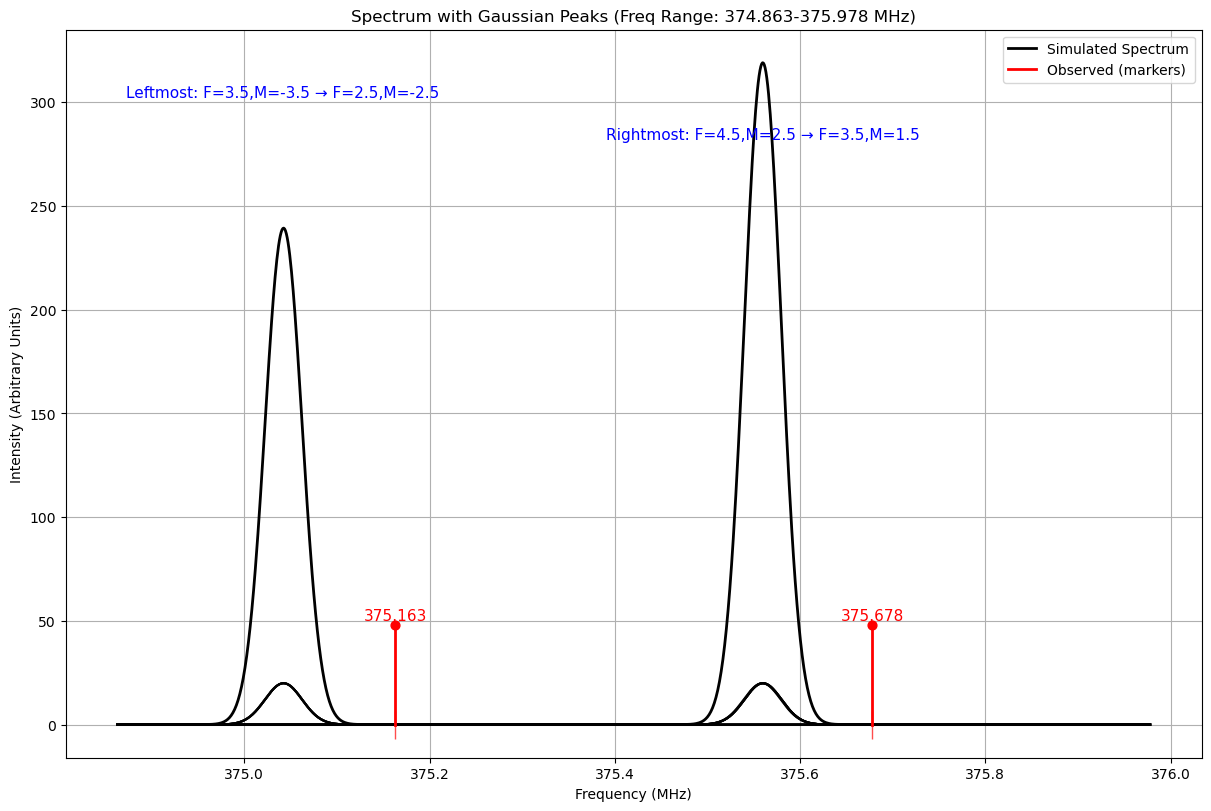


Molecular constants used:
  Be: 7334.100000
  e2Qq0: -3153.061000
  muE: 1.101295
  Gamma_SR: -87.187142
  Gamma_Prime: 14.233846
  bFYb: -1880.966534
  cYb: -92.159499
  q_lD: 12.494150
  p_lD: 12.766362
  bFH: 4.070000
  cH: 5.490000
  Ez_field: 0.0
  B_field: 1e-08


In [13]:
def plot_spectrum_with_constants(
    Be=None, e2Qq0=None, muE=None, Gamma_SR=None, Gamma_Prime=None,
    bFYb=None, cYb=None, q_lD=None, p_lD=None,
    bFH=None, cH=None, bfH=None,  # bFH is the model key; bfH is accepted as alias
    Ez_field=0.0, B_field=1e-8,
    freq_min=None, freq_max=None, auto_window=True, window_pad=0.30,
    freq_width=0.02, obs_marker_frac=0.15, obs_label=True, obs_rug=True,
    show_predicted_centers=True,
):
    """
    Plot two-photon spectrum with specified molecular constants.

    Parameters
    ----------
    Be, e2Qq0, muE, Gamma_SR, Gamma_Prime, bFYb, cYb, q_lD, p_lD, bFH, cH : float, optional
        Molecular constants. If None, uses current value from X010_173.
    Ez_field : float
        Electric field (V/cm) for the spectrum and predicted centers.
    B_field : float
        Magnetic field (T) for the spectrum and predicted centers.
    freq_min, freq_max : float, optional
        Frequency range for plot (MHz). If None and auto_window=True, auto-calculates.
    auto_window : bool
        Automatically set window around predicted + observed peaks.
    window_pad : float
        Padding (MHz) around auto window.
    freq_width : float
        Gaussian width for peaks (MHz).
    obs_marker_frac : float
        Fraction of spectrum max for observed marker height.
    obs_label : bool
        Annotate observed markers with frequency labels.
    obs_rug : bool
        Draw small ticks at observed frequencies.
    show_predicted_centers : bool
        Show vertical lines at predicted center frequencies.
    """
    orig_params = current_parameter_dict(X010_173)
    new_params = dict(orig_params)

    # Collect updates (use bFH, cH names used in Hamiltonian)
    param_updates = {
        'Be': Be, 'e2Qq0': e2Qq0, 'muE': muE,
        'Gamma_SR': Gamma_SR, 'Gamma_Prime': Gamma_Prime,
        'bFYb': bFYb, 'cYb': cYb, 'q_lD': q_lD, 'p_lD': p_lD,
        'bFH': bFH, 'cH': cH,
    }
    for k, v in param_updates.items():
        if v is not None:
            new_params[k] = v
    # Accept legacy/alias bfH by mapping to bFH
    if bfH is not None:
        new_params['bFH'] = bfH

    set_state_parameters(X010_173, new_params)

    try:
        # Load observed peaks for the specified Ez_field
        try:
            obs_matching = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0) - Ez_field) < 0.1]
            if obs_matching:
                obs_freqs = np.asarray(obs_matching[0].get("freqs", []), float)
                print(f"✓ Loaded observed spectrum at Ez={Ez_field} V/cm with {len(obs_freqs)} peaks")
            else:
                obs_freqs = np.array([], float)
                available_fields = sorted(set(s.get("Ez", 0.0) for s in OBS_SPECTRA))
                print(f"Warning: No observed spectrum found for Ez={Ez_field} V/cm. Available fields: {available_fields}")
        except Exception as e:
            print(f"Warning: could not read OBS_SPECTRA: {e}")
            obs_freqs = np.array([], float)

        # Predicted centers
        try:
            pred_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET, Ez=Ez_field, B=B_field)
            pred_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET, Ez=Ez_field, B=B_field)
        except Exception as e:
            print(f"Warning: could not compute predicted centers: {e}")
            pred_lower = np.nan
            pred_higher = np.nan

        # Frequency window
        offset = 0.0
        if auto_window and (freq_min is None or freq_max is None):
            candidates = []
            for c in [pred_lower, pred_higher]:
                if c is not None and not np.isnan(c):
                    candidates.append(c - offset)
            if obs_freqs.size > 0:
                candidates.extend(list(obs_freqs - offset))
            if candidates:
                freq_min = min(candidates) - window_pad
                freq_max = max(candidates) + window_pad
            else:
                freq_min, freq_max = 374.5, 375.75
        elif freq_min is None or freq_max is None:
            freq_min, freq_max = 374.5, 375.75

        out = X010_173.calculate_two_photon_spectrum(
            Ez_field, B_field, TRANSITION_INDEX_SET, parity_sign=1,
            laser_polarization='orth', allowed_transitions=ALLOWED_TRANSITIONS
        )
        transitions = out[1]
        filtered_transitions = [t for t in transitions if 'freq' in t and (freq_min <= (t['freq'] - offset) <= freq_max)]

        freq_range = np.linspace(freq_min, freq_max, 1200)
        spectrum = np.zeros_like(freq_range)

        fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

        if filtered_transitions:
            for t in filtered_transitions:
                freq = (t['freq'] - offset)
                gp = norm.pdf(freq_range, loc=freq, scale=freq_width)
                spectrum += gp
                ax.plot(freq_range, gp, color='black', alpha=0.4)
        else:
            try:
                freqs_lower = extract_transition_freqs(
                    X010_173, LOWER_PAIR, Ez=Ez_field, B=B_field, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
                freqs_higher = extract_transition_freqs(
                    X010_173, HIGHER_PAIR, Ez=Ez_field, B=B_field, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
                for f in list(freqs_lower) + list(freqs_higher):
                    if freq_min <= f - offset <= freq_max:
                        gp = norm.pdf(freq_range, loc=f - offset, scale=freq_width)
                        spectrum += gp
                        ax.plot(freq_range, gp, color='black', alpha=0.4)
                if spectrum.max() == 0:
                    print("Warning: No predicted peaks within the auto window; showing flat simulated spectrum.")
            except Exception as e:
                print(f"Fallback predicted peaks failed: {e}")

        ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)

        # Annotate leftmost and rightmost predicted transitions with state indices (if available)
        if filtered_transitions:
            def format_quantum_numbers(tdict):
                # Extract F and M quantum numbers for both states (should be half-integers)
                # State 0: 'F0', 'M0'
                # State 1: 'F1', 'M1'
                F0 = tdict.get('F0', None)
                M0 = tdict.get('M0', None)
                F1 = tdict.get('F1', None)
                M1 = tdict.get('M1', None)

                def format_half_int(val):
                    # Format as float, but remove trailing .0 for integers
                    if val is None:
                        return None
                    else:
                        return str(float(val))

                # Build label: show F,M for both states or just M if F is missing
                parts = []
                if F0 is not None and M0 is not None:
                    f0_str = format_half_int(F0)
                    m0_str = format_half_int(M0)
                    parts.append(f"F={f0_str},M={m0_str}")
                elif M0 is not None:
                    m0_str = format_half_int(M0)
                    parts.append(f"M={m0_str}")
                
                if F1 is not None and M1 is not None:
                    f1_str = format_half_int(F1)
                    m1_str = format_half_int(M1)
                    parts.append(f"F={f1_str},M={m1_str}")
                elif M1 is not None:
                    m1_str = format_half_int(M1)
                    parts.append(f"M={m1_str}")
                
                if parts:
                    return " → ".join(parts)
                return "M_F?"

            left_t = min(filtered_transitions, key=lambda t: t.get('freq', np.inf))
            right_t = max(filtered_transitions, key=lambda t: t.get('freq', -np.inf))

            y_top = ax.get_ylim()[1]
            ax.text(left_t['freq'] - offset, y_top * 0.92, f"Leftmost: {format_quantum_numbers(left_t)}", color='blue', ha='center', va='top', fontsize=11)
            ax.text(right_t['freq'] - offset, y_top * 0.86, f"Rightmost: {format_quantum_numbers(right_t)}", color='blue', ha='center', va='top', fontsize=11)

        if show_predicted_centers:
            for center, lbl in [(pred_lower, 'Predicted Lower'), (pred_higher, 'Predicted Higher')]:
                if center is not None and not np.isnan(center) and (freq_min <= center - offset <= freq_max):
                    ax.axvline(center - offset, color='gray', linestyle='--', linewidth=2, alpha=0.7)
                    ax.text(center - offset, ax.get_ylim()[1] * 0.95, f"{lbl}: {center:.3f}", color='gray', ha='center')

        if obs_freqs.size > 0:
            in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
            if in_win.size > 0:
                marker_h = obs_marker_frac * (spectrum.max() if spectrum.max() else 1)
                for of in in_win:
                    x = of - offset
                    ax.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
                    ax.scatter([x], [marker_h], color='red', s=40, marker='o', zorder=4)
                    if obs_label:
                        ax.text(x, marker_h * 1.05, f"{of:.3f}", color='red', fontsize=11, ha='center')
                if obs_rug:
                    ax.plot(in_win - offset, np.full_like(in_win, -0.02), '|', color='red', markersize=20, alpha=0.7)
                ax.plot([], [], color='red', lw=2, label='Observed (markers)')
            else:
                print("Observed peaks lie outside current window; consider increasing window_pad.")
        else:
            print("Observed 0 V/cm spectrum not available; overlay skipped.")

        ax.set_xlabel('Frequency (MHz)')
        ax.set_ylabel('Intensity (Arbitrary Units)')
        ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min:.3f}-{freq_max:.3f} MHz)')
        ax.grid(True)
        ax.legend()
        plt.show()

        print("\nMolecular constants used:")
        for key in ['Be', 'e2Qq0', 'muE', 'Gamma_SR', 'Gamma_Prime', 'bFYb', 'cYb', 'q_lD', 'p_lD', 'bFH', 'cH']:
            if key in new_params:
                print(f"  {key}: {new_params[key]:.6f}")
        print(f"  Ez_field: {Ez_field}")
        print(f"  B_field: {B_field}")

    finally:
        set_state_parameters(X010_173, orig_params)


# Example usage: plot with current parameters at finite field
plot_spectrum_with_constants(Ez_field=0.0, B_field=1e-8)


✓ Loaded observed spectrum at Ez=0.0 V/cm with 2 peaks


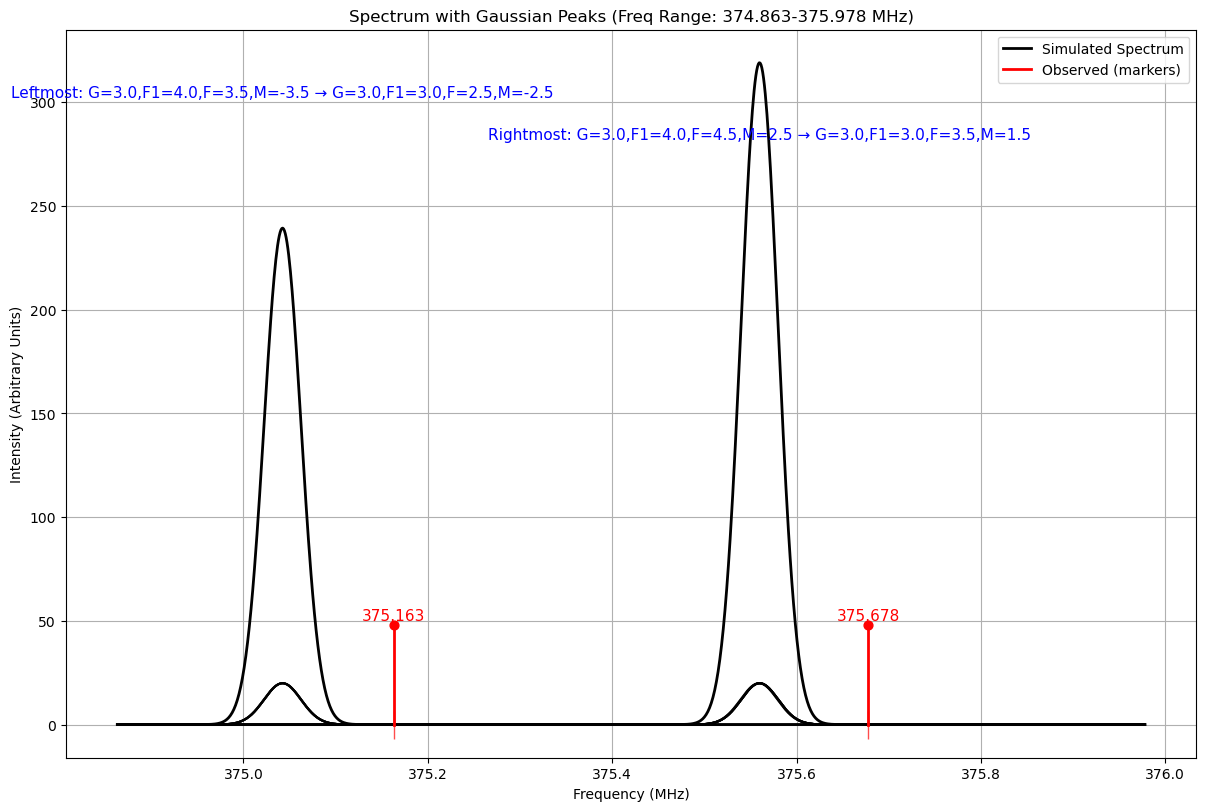


Molecular constants used:
  Be: 7334.100000
  e2Qq0: -3153.061000
  muE: 1.101295
  Gamma_SR: -87.187142
  Gamma_Prime: 14.233846
  bFYb: -1880.966534
  cYb: -92.159499
  q_lD: 12.494150
  p_lD: 12.766362
  bFH: 4.070000
  cH: 5.490000
  Ez_field: 0.0
  B_field: 1e-08


In [14]:
def plot_spectrum_with_constants_2(
    Be=None, e2Qq0=None, muE=None, Gamma_SR=None, Gamma_Prime=None,
    bFYb=None, cYb=None, q_lD=None, p_lD=None,
    bFH=None, cH=None, bfH=None,  # bFH is the model key; bfH is accepted as alias
    Ez_field=0.0, B_field=1e-8,
    freq_min=None, freq_max=None, auto_window=True, window_pad=0.30,
    freq_width=0.02, obs_marker_frac=0.15, obs_label=True, obs_rug=True,
    show_predicted_centers=True,
):
    """
    Plot two-photon spectrum with specified molecular constants.

    Parameters
    ----------
    Be, e2Qq0, muE, Gamma_SR, Gamma_Prime, bFYb, cYb, q_lD, p_lD, bFH, cH : float, optional
        Molecular constants. If None, uses current value from X010_173.
    Ez_field : float
        Electric field (V/cm) for the spectrum and predicted centers.
    B_field : float
        Magnetic field (T) for the spectrum and predicted centers.
    freq_min, freq_max : float, optional
        Frequency range for plot (MHz). If None and auto_window=True, auto-calculates.
    auto_window : bool
        Automatically set window around predicted + observed peaks.
    window_pad : float
        Padding (MHz) around auto window.
    freq_width : float
        Gaussian width for peaks (MHz).
    obs_marker_frac : float
        Fraction of spectrum max for observed marker height.
    obs_label : bool
        Annotate observed markers with frequency labels.
    obs_rug : bool
        Draw small ticks at observed frequencies.
    show_predicted_centers : bool
        Show vertical lines at predicted center frequencies.
    """
    orig_params = current_parameter_dict(X010_173)
    new_params = dict(orig_params)

    # Collect updates (use bFH, cH names used in Hamiltonian)
    param_updates = {
        'Be': Be, 'e2Qq0': e2Qq0, 'muE': muE,
        'Gamma_SR': Gamma_SR, 'Gamma_Prime': Gamma_Prime,
        'bFYb': bFYb, 'cYb': cYb, 'q_lD': q_lD, 'p_lD': p_lD,
        'bFH': bFH, 'cH': cH,
    }
    for k, v in param_updates.items():
        if v is not None:
            new_params[k] = v
    # Accept legacy/alias bfH by mapping to bFH
    if bfH is not None:
        new_params['bFH'] = bfH

    set_state_parameters(X010_173, new_params)

    try:
        # Load observed peaks for the specified Ez_field
        try:
            obs_matching = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0) - Ez_field) < 0.1]
            if obs_matching:
                obs_freqs = np.asarray(obs_matching[0].get("freqs", []), float)
                print(f"✓ Loaded observed spectrum at Ez={Ez_field} V/cm with {len(obs_freqs)} peaks")
            else:
                obs_freqs = np.array([], float)
                available_fields = sorted(set(s.get("Ez", 0.0) for s in OBS_SPECTRA))
                print(f"Warning: No observed spectrum found for Ez={Ez_field} V/cm. Available fields: {available_fields}")
        except Exception as e:
            print(f"Warning: could not read OBS_SPECTRA: {e}")
            obs_freqs = np.array([], float)

        # Predicted centers
        try:
            pred_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET, Ez=Ez_field, B=B_field)
            pred_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET, Ez=Ez_field, B=B_field)
        except Exception as e:
            print(f"Warning: could not compute predicted centers: {e}")
            pred_lower = np.nan
            pred_higher = np.nan

        # Frequency window
        offset = 0.0
        if auto_window and (freq_min is None or freq_max is None):
            candidates = []
            for c in [pred_lower, pred_higher]:
                if c is not None and not np.isnan(c):
                    candidates.append(c - offset)
            if obs_freqs.size > 0:
                candidates.extend(list(obs_freqs - offset))
            if candidates:
                freq_min = min(candidates) - window_pad
                freq_max = max(candidates) + window_pad
            else:
                freq_min, freq_max = 374.5, 375.75
        elif freq_min is None or freq_max is None:
            freq_min, freq_max = 374.5, 375.75

        out = X010_173.calculate_two_photon_spectrum(
            Ez_field, B_field, TRANSITION_INDEX_SET, parity_sign=1,
            laser_polarization='orth', allowed_transitions=None
        )
        transitions = out[1]
        filtered_transitions = [t for t in transitions if 'freq' in t and (freq_min <= (t['freq'] - offset) <= freq_max)]

        freq_range = np.linspace(freq_min, freq_max, 1200)
        spectrum = np.zeros_like(freq_range)

        fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

        if filtered_transitions:
            for t in filtered_transitions:
                freq = (t['freq'] - offset)
                gp = norm.pdf(freq_range, loc=freq, scale=freq_width)
                spectrum += gp
                ax.plot(freq_range, gp, color='black', alpha=0.4)
        else:
            try:
                freqs_lower = extract_transition_freqs(
                    X010_173, LOWER_PAIR, Ez=Ez_field, B=B_field, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=None)
                freqs_higher = extract_transition_freqs(
                    X010_173, HIGHER_PAIR, Ez=Ez_field, B=B_field, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=None)
                for f in list(freqs_lower) + list(freqs_higher):
                    if freq_min <= f - offset <= freq_max:
                        gp = norm.pdf(freq_range, loc=f - offset, scale=freq_width)
                        spectrum += gp
                        ax.plot(freq_range, gp, color='black', alpha=0.4)
                if spectrum.max() == 0:
                    print("Warning: No predicted peaks within the auto window; showing flat simulated spectrum.")
            except Exception as e:
                print(f"Fallback predicted peaks failed: {e}")

        ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)

        # Annotate leftmost and rightmost predicted transitions with state indices (if available)
        if filtered_transitions:
            def format_quantum_numbers(tdict):
                # Extract F and M quantum numbers for both states (should be half-integers)
                # State 0: 'F0', 'M0'
                # State 1: 'F1', 'M1'
                F0 = tdict.get('F0', None)
                M0 = tdict.get('M0', None)
                F1 = tdict.get('F1', None)
                M1 = tdict.get('M1', None)
                F11 = tdict.get('F11', None)
                F10 = tdict.get('F10', None)
                G1 = tdict.get('G1', None)
                G0 = tdict.get('G0', None)

                def format_half_int(val):
                    # Format as float, but remove trailing .0 for integers
                    if val is None:
                        return None
                    else:
                        return str(float(val))

                # Build label: show F,M for both states or just M if F is missing
                parts = []
                if F0 is not None and M0 is not None:
                    f0_str = format_half_int(F0)
                    m0_str = format_half_int(M0)
                    G0_str = format_half_int(G0)
                    F10_str = format_half_int(F10)                    
                    parts.append(f"G={G0_str},F1={F10_str},F={f0_str},M={m0_str}")
                elif M0 is not None:
                    m0_str = format_half_int(M0)
                    parts.append(f"M={m0_str}")
                
                if F1 is not None and M1 is not None:
                    f1_str = format_half_int(F1)
                    m1_str = format_half_int(M1)
                    G1_str = format_half_int(G1)
                    F11_str = format_half_int(F11)                    
                    parts.append(f"G={G1_str},F1={F11_str},F={f1_str},M={m1_str}")
                elif M1 is not None:
                    m1_str = format_half_int(M1)
                    parts.append(f"M={m1_str}")
                
                if parts:
                    return " → ".join(parts)
                return "M_F?"

            left_t = min(filtered_transitions, key=lambda t: t.get('freq', np.inf))
            right_t = max(filtered_transitions, key=lambda t: t.get('freq', -np.inf))

            y_top = ax.get_ylim()[1]
            ax.text(left_t['freq'] - offset, y_top * 0.92, f"Leftmost: {format_quantum_numbers(left_t)}", color='blue', ha='center', va='top', fontsize=11)
            ax.text(right_t['freq'] - offset, y_top * 0.86, f"Rightmost: {format_quantum_numbers(right_t)}", color='blue', ha='center', va='top', fontsize=11)

        if show_predicted_centers:
            for center, lbl in [(pred_lower, 'Predicted Lower'), (pred_higher, 'Predicted Higher')]:
                if center is not None and not np.isnan(center) and (freq_min <= center - offset <= freq_max):
                    ax.axvline(center - offset, color='gray', linestyle='--', linewidth=2, alpha=0.7)
                    ax.text(center - offset, ax.get_ylim()[1] * 0.95, f"{lbl}: {center:.3f}", color='gray', ha='center')

        if obs_freqs.size > 0:
            in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
            if in_win.size > 0:
                marker_h = obs_marker_frac * (spectrum.max() if spectrum.max() else 1)
                for of in in_win:
                    x = of - offset
                    ax.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
                    ax.scatter([x], [marker_h], color='red', s=40, marker='o', zorder=4)
                    if obs_label:
                        ax.text(x, marker_h * 1.05, f"{of:.3f}", color='red', fontsize=11, ha='center')
                if obs_rug:
                    ax.plot(in_win - offset, np.full_like(in_win, -0.02), '|', color='red', markersize=20, alpha=0.7)
                ax.plot([], [], color='red', lw=2, label='Observed (markers)')
            else:
                print("Observed peaks lie outside current window; consider increasing window_pad.")
        else:
            print("Observed 0 V/cm spectrum not available; overlay skipped.")

        ax.set_xlabel('Frequency (MHz)')
        ax.set_ylabel('Intensity (Arbitrary Units)')
        ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min:.3f}-{freq_max:.3f} MHz)')
        ax.grid(True)
        ax.legend()
        plt.show()

        print("\nMolecular constants used:")
        for key in ['Be', 'e2Qq0', 'muE', 'Gamma_SR', 'Gamma_Prime', 'bFYb', 'cYb', 'q_lD', 'p_lD', 'bFH', 'cH']:
            if key in new_params:
                print(f"  {key}: {new_params[key]:.6f}")
        print(f"  Ez_field: {Ez_field}")
        print(f"  B_field: {B_field}")

    finally:
        set_state_parameters(X010_173, orig_params)


# Example usage: plot with current parameters at finite field
plot_spectrum_with_constants_2(Ez_field=0.0, B_field=1e-8)


Observed 0 V/cm spectrum not available; overlay skipped.


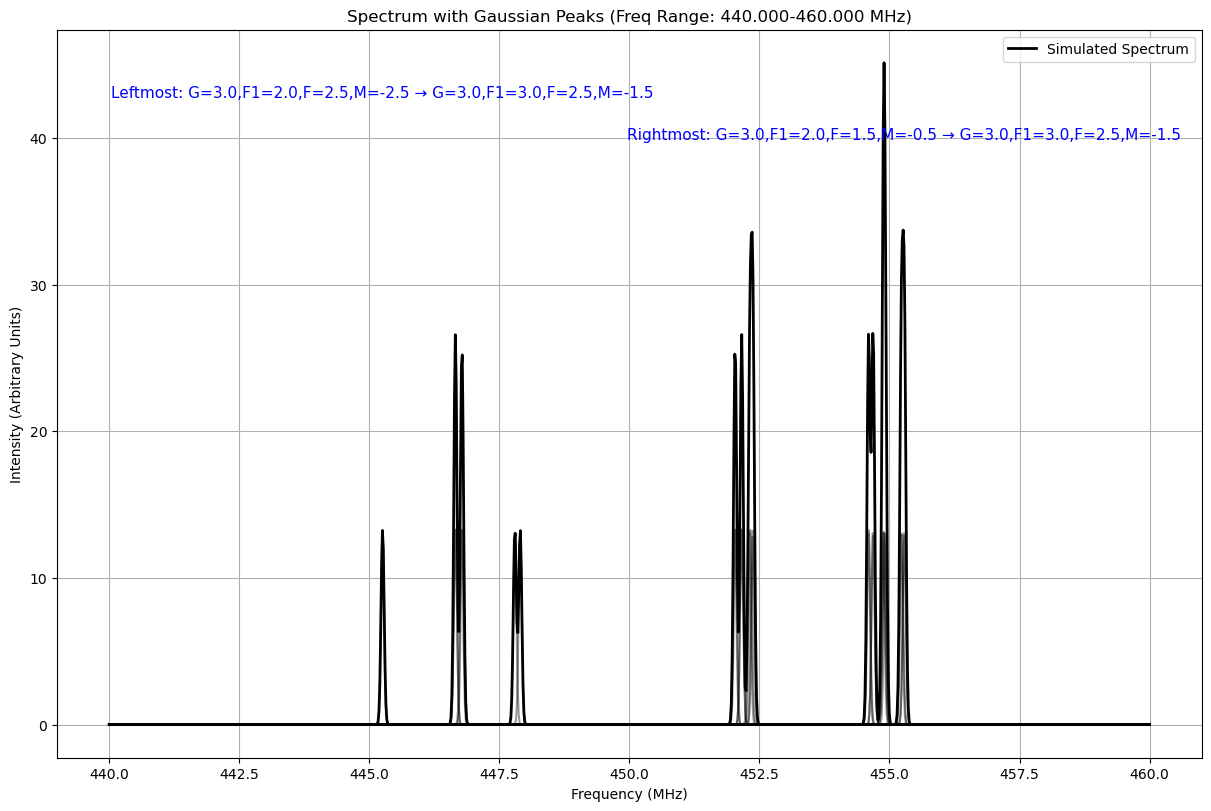


Molecular constants used:
  Be: 7334.130787
  e2Qq0: -3154.200000
  muE: 1.087370
  Gamma_SR: -87.187142
  Gamma_Prime: 14.233846
  bFYb: -1880.966534
  cYb: -92.159499
  q_lD: 12.494150
  p_lD: 12.766362
  bFH: 4.070000
  cH: 5.490000
  Ez_field: 50.0
  B_field: 1e-08


In [15]:
plot_spectrum_with_constants_2(
    Be=7334.130787, 
    e2Qq0=-3154.2, 
    muE=1.087370, 
    Gamma_SR=-87.187142, 
    Gamma_Prime=14.233846,
    bFYb=-1880.966534, 
    cYb=-92.159499, 
    q_lD=12.494150, 
    p_lD=12.766362,
    bfH= 4.07,
    cH= 5.49,
    Ez_field=50.0,   # V/cm
    B_field=1e-8,
    freq_min=440,
    freq_max=460,
    freq_width=0.03,          # sharper peaks
    obs_marker_frac=0.25      # taller markers
)

✓ Loaded observed spectrum at Ez=40.0 V/cm with 8 peaks


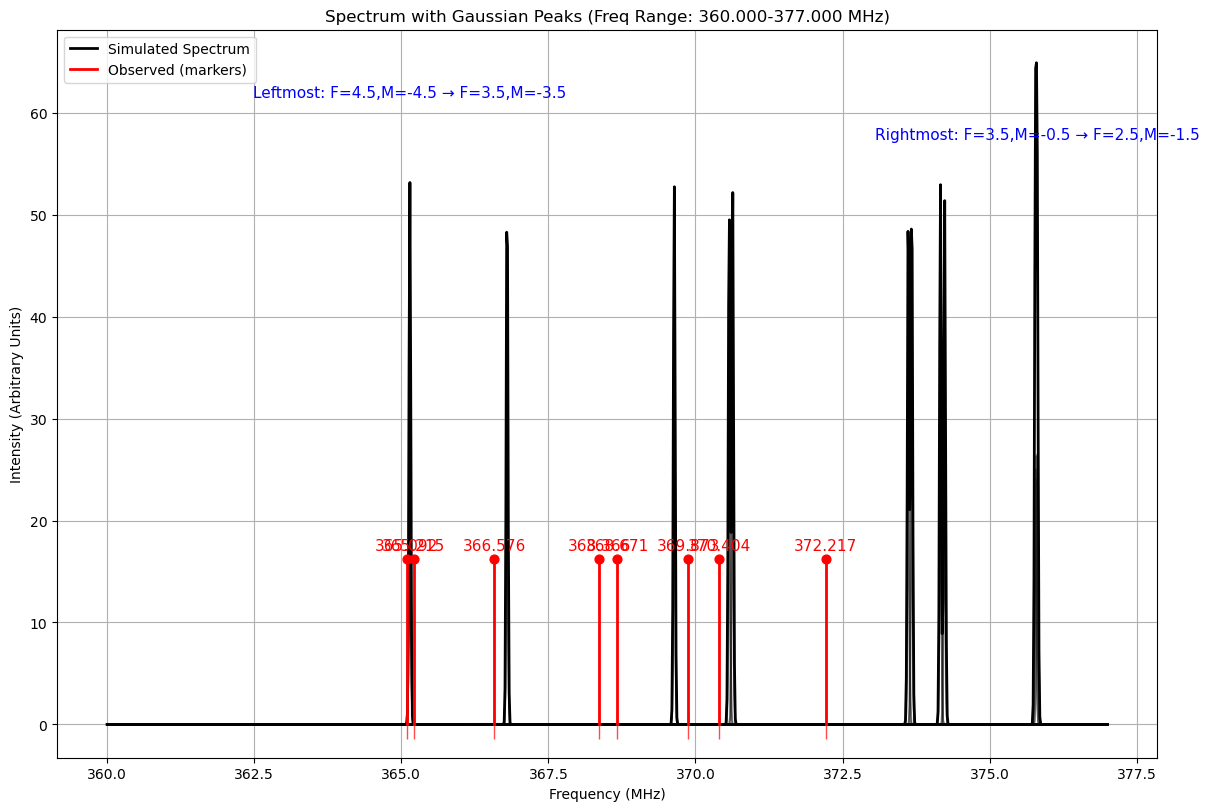


Molecular constants used:
  Be: 7334.100000
  e2Qq0: -3154.200000
  muE: 0.902517
  Gamma_SR: -87.187142
  Gamma_Prime: 14.233846
  bFYb: -1880.966534
  cYb: -92.159499
  q_lD: 12.494150
  p_lD: 12.766362
  bFH: 4.070000
  cH: 5.490000
  Ez_field: 40.0
  B_field: 1e-08


In [36]:
# ============================================================
# Example: Plot at Ez = 20 V/cm
# ============================================================
plot_spectrum_with_constants(
    Be=7334.100000, 
    e2Qq0=-3154.2 - 0, 
    muE=0.83*(2.16)*0.503412, 
    Gamma_SR=-87.187142 - 0,  #####
    Gamma_Prime=14.233846, 
    bFYb=-1880.966534 - 0,  
    cYb=-92.159499 + 0,  #####
    q_lD=12.494150 - 0, #####
    p_lD=12.766362 - 0,
    bfH=4.07 - 0, #####
    cH=5.49,
    Ez_field=40.0,   # V/cm
    B_field=1e-8,
    freq_min=360,
    freq_max=377,
    freq_width=0.015,
    obs_marker_frac=0.25
)


✓ Loaded observed spectrum at Ez=40.0 V/cm with 8 peaks


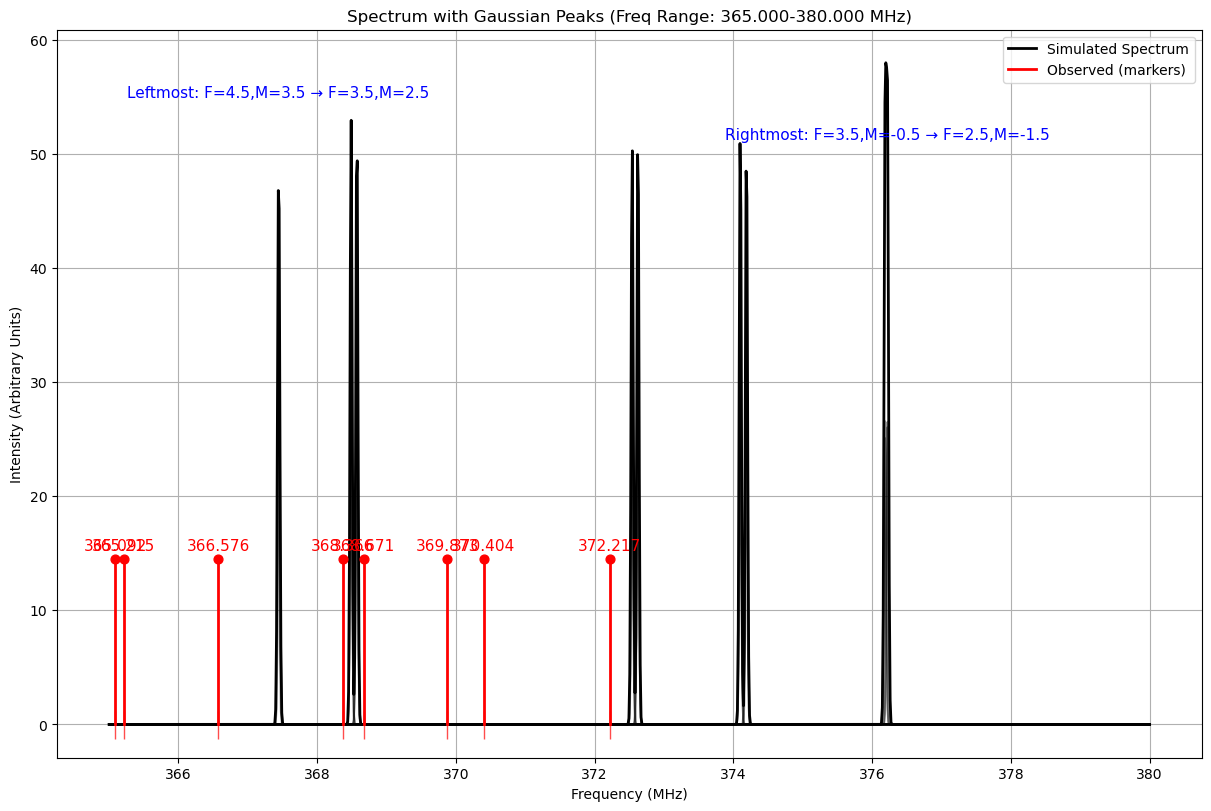


Molecular constants used:
  Be: 7334.100000
  e2Qq0: -3154.200000
  muE: 1.101295
  Gamma_SR: -87.187142
  Gamma_Prime: 14.233846
  bFYb: -1880.966534
  cYb: -92.159499
  q_lD: 12.494150
  p_lD: 12.766362
  bFH: 4.070000
  cH: 5.490000
  Ez_field: 40.0
  B_field: 1e-08


In [38]:
# ============================================================
# Example: Plot at Ez = 40 V/cm
# ============================================================
plot_spectrum_with_constants(
    Be=7334.100000, 
    e2Qq0=-3154.2, 
    muE=1.101295, 
    Gamma_SR=-87.187142, 
    Gamma_Prime=14.233846,
    bFYb=-1880.966534, 
    cYb=-92.159499, 
    q_lD=12.494150, 
    p_lD=12.766362,
    bfH=4.07,
    cH=5.49,
    Ez_field=40.0,   # V/cm
    B_field=1e-8,
    freq_min=365,
    freq_max=380,
    freq_width=0.015,
    obs_marker_frac=0.25
)


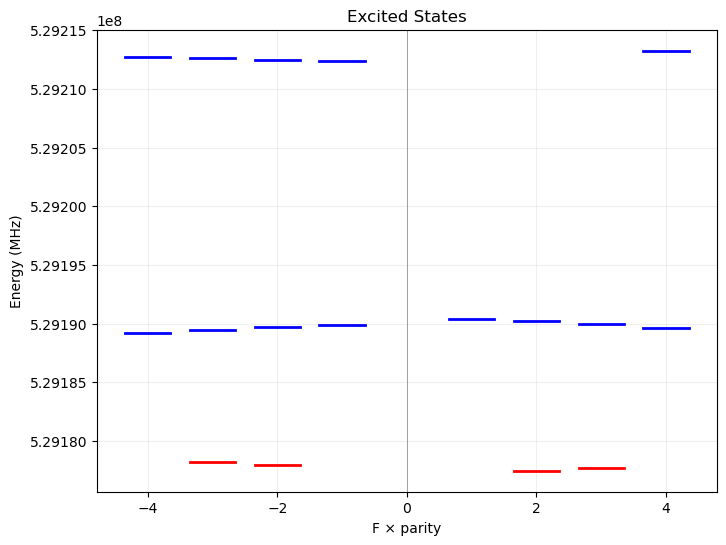

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.constants import c  # speed of light in m/s

All_excited_states_assignments = [
[1, 0.5, 2, 1, 17651.459810673736],
 [1, 0.5, 3, 1, 17651.468732601665],
 [1, 0.5, 2, -1, 17651.47531461785],
 [1, 0.5, 3, -1, 17651.484772843334],
 [1, 1.5, 4, -1, 17651.851058394142],
 [1, 1.5, 3, -1, 17651.860713049806],
 [1, 1.5, 4, 1, 17651.866951578595],
 [1, 1.5, 2, -1, 17651.869167705463],
 [1, 1.5, 1, -1, 17651.874367705463],
 [1, 1.5, 3, 1, 17651.87647912011],
 [1, 1.5, 2, 1, 17651.88533753238],
 [1, 1.5, 1, 1, 17651.890233326245],
 [2, 1.5, 1, -1, 17652.624167705464],
 [2, 1.5, 2, -1, 17652.6279130498],
 [2, 1.5, 3, -1, 17652.6319130498],
 [2, 1.5, 4, -1, 17652.63665839414],
 [2, 1.5, 4, 1, 17652.654017886474]]



df = pd.DataFrame(
    All_excited_states_assignments,
    columns=["N", "J", "F", "parity", "pos_cm1"]
)

# Convert cm^-1 to MHz: E (Hz) = (c / lambda); wavenumber = 1/lambda (cm^-1)
# So Hz = pos_cm1 * (c * 100) ; MHz = Hz / 1e6
df["pos_MHz"] = df["pos_cm1"] * (c * 100) / 1e6
df["F_parity"] = df["F"] * df["parity"]



df = pd.DataFrame(
    All_excited_states_assignments,
    columns=["N", "J", "F", "parity", "pos_cm1"]
)

df["pos_MHz"] = df["pos_cm1"] * (c * 100) / 1e6
df["F_parity"] = df["F"] * df["parity"]
df["is_ambiguous"] = (df["F"] % 1 != 0)

colors = {0.5: "red", 1.5: "blue"}  # definitive color by J
seg_halfwidth = 0.35

plt.figure(figsize=(8, 6))

for _, row in df.iterrows():
    x0 = row["F_parity"] - seg_halfwidth
    x1 = row["F_parity"] + seg_halfwidth
    y = row["pos_MHz"]

    if row["is_ambiguous"]:
        # yellow highlight for non-definitive assignments
        plt.plot([x0, x1], [y, y], color="gold", linewidth=3)
        plt.plot([x0, x1], [y, y], color="black", linewidth=1)  # thin outline
    else:
        plt.plot([x0, x1], [y, y], color=colors.get(row["J"], "black"), linewidth=2)

plt.xlabel("F × parity")
plt.ylabel("Energy (MHz)")
plt.title("Excited States")
plt.axvline(0, color="gray", linewidth=0.5)
plt.grid(alpha=0.2)
plt.show()



In [ ]:
# ============================================================
# Transitions: X010_173 (N=1) -> excited states (N=1 only)
# Selection rule: |ΔF1| <= 1 (excited F in list is F1)
# Parity rule: opposite parity (ground ↔ excited)
# Ground parity filter: set ground_parity_select to +1 or -1 (or None)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import c
from matplotlib.lines import Line2D

try:
    import mplcursors
    MPLCURSORS_AVAILABLE = True
except Exception:
    mplcursors = None
    MPLCURSORS_AVAILABLE = False

def compute_transition_spectrum(
    state,
    excited_assignments,
    ground_parity_select=1,
    offset_MHz=230,
    zoom_min_cm1=None,
    zoom_max_cm1=None,
    show_labels=True,
    label_fontsize=8,
    use_hover=True,
    Ez=EZ_FIELD,
    B=B_FIELD,
    plot_full=False,
    
    
    plot_zoom=True,
    display_table=True,
    title_full="Allowed transitions: X010_173 (N=1) → excited N=1 (|ΔF1| ≤ 1, opposite parity)",
    include_legend_in_pdf=True,
    legend_from_labels=False,
):
    # ---- Excited states (treat provided F as F1) ----
    excited_df = pd.DataFrame(
        excited_assignments,
        columns=["N", "J", "F1", "parity", "pos_cm1"],
    )
    excited_df = excited_df[excited_df["N"] == 1].reset_index(drop=True)
    excited_df["excited_id"] = excited_df.index

    # ---- Ground state assignments from X010_173 (N=1 only) ----
    def _state_assignments(state, indices, Ez=Ez, B=B):
        evals, evecs = state.eigensystem(Ez, B, set_attr=True)
        indices = np.unique(np.asarray(indices, dtype=int))
        if indices.size == 0:
            return pd.DataFrame()
        evecs_sub = evecs[indices]
        energies = np.asarray(evals)[indices]
        parities = np.einsum('ni,ij,nj->n', evecs_sub, state.Parity_mat, evecs_sub)
        maxidx = np.argmax(evecs_sub**2, axis=1)
        q = state.q_numbers
        return pd.DataFrame({
            "state_index": indices,
            "energy_MHz": energies,
            "Parity": parities,
            "N": np.asarray(q["N"])[maxidx],
            "M": np.asarray(q["M"])[maxidx],
            "F": np.asarray(q["F"])[maxidx],
            "F1": np.asarray(q.get("F1", np.zeros_like(maxidx, dtype=float)))[maxidx],
            "G": np.asarray(q.get("G", np.zeros_like(maxidx, dtype=float)))[maxidx],
        })

    ground_indices = state.select_q({"N": 1})
    ground_df = _state_assignments(state, ground_indices)
    ground_df = ground_df[ground_df["N"] == 1].reset_index(drop=True)
    if ground_parity_select in (+1, -1):
        ground_df = ground_df[np.sign(ground_df["Parity"]) == ground_parity_select].reset_index(drop=True)

    # ---- Build all possible transitions (ΔF1 <= 1 and opposite parity) ----
    ground_df["_key"] = 1
    excited_df["_key"] = 1
    transitions_df = ground_df.merge(excited_df, on="_key", suffixes=("_g", "_e")).drop(columns=["_key"])
    delta_f1_mask = np.abs(transitions_df["F1_e"] - transitions_df["F1_g"]) <= delta_f1_rule
    parity_mask = np.sign(transitions_df["Parity"]) * np.sign(transitions_df["parity"]) == -1
    transitions_df = transitions_df[delta_f1_mask & parity_mask].reset_index(drop=True)

    # ---- Energy conversion and transition energies (cm^-1) ----
    MHz_to_cm1 = 1e6 / (c * 100.0)
    transitions_df["ground_cm1"] = transitions_df["energy_MHz"] * MHz_to_cm1
    transitions_df["transition_cm1"] = transitions_df["pos_cm1"] - transitions_df["ground_cm1"]
    transitions_df["transition_cm1"] = transitions_df["transition_cm1"] - (offset_MHz * MHz_to_cm1) - 319.90932
    transitions_df["transition_MHz"] = transitions_df["transition_cm1"] * (c * 100.0) / 1e6

    # ---- Sort and display ----
    transitions_df = transitions_df.sort_values("transition_cm1").reset_index(drop=True)
    if display_table:
        display(transitions_df)

    def _col(row, *names):
        for name in names:
            if name in row.index:
                return row[name]
        return None

    def _fmt_half(val):
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return "?"
        return str(float(val)).rstrip('0').rstrip('.') if isinstance(val, (float, np.floating)) else str(val)

    def _format_label(row):
        freq = row.get("transition_cm1", np.nan)
        freq_str = f"{freq:.6f} cm$^{{-1}}$"
        g_val = _col(row, "G_g", "G")
        f1_g = _col(row, "F1_g")
        f1_e = _col(row, "F1_e")
        j_e = _col(row, "J_e", "J")

        g_str = f"G={_fmt_half(g_val)}"
        f1g_str = f"F1_g={_fmt_half(f1_g)}"
        f1e_str = f"F1_e={_fmt_half(f1_e)}"
        je_str = f"J_e={_fmt_half(j_e)}"

        return f"{freq_str} | {g_str}, {f1g_str} → {f1e_str}, {je_str}"

    def _label_key(row):
        return (
            _fmt_half(_col(row, "G_g", "G")),
            _fmt_half(_col(row, "F1_g")),
            _fmt_half(_col(row, "F1_e")),
            _fmt_half(_col(row, "J_e", "J")),
        )

    def _plot_sticks(df, title, x_min=None, x_max=None):
        if df.empty:
            print("No transitions to plot.")
            return
        plt.figure(figsize=(9, 6))
        y = np.ones(len(df))
        sticks = plt.vlines(
            df["transition_cm1"],
            0,
            y,
            color="black",
            linewidth=1,
            label="Allowed transitions",
        )

        legend_rows = df
        if legend_from_labels:
            seen = set()
            legend_rows = []
            for _, row in df.iterrows():
                key = _label_key(row)
                if key in seen:
                    continue
                seen.add(key)
                legend_rows.append(row)

        legend_state_indices = set()
        for row in legend_rows:
            idx = row.get("state_index", None)
            if idx is not None:
                legend_state_indices.add(idx)

        # State index annotations above lines (only those in legend)
        for _, row in df.iterrows():
            state_idx = row.get("state_index", None)
            if state_idx is None or state_idx not in legend_state_indices:
                continue
            try:
                idx_label = str(int(state_idx))
            except Exception:
                idx_label = str(state_idx)
            plt.text(
                row["transition_cm1"],
                1.04,
                idx_label,
                ha="center",
                va="bottom",
                fontsize=max(6, label_fontsize - 2),
                rotation=90,
            )

        if show_labels:
            for idx, (_, row) in enumerate(df.iterrows()):
                side = -1 if (idx % 2 == 0) else 1
                plt.annotate(
                    _format_label(row),
                    xy=(row["transition_cm1"], 1.0),
                    xytext=(12 * side, 0),
                    textcoords="offset points",
                    rotation=90,
                    ha="left" if side > 0 else "right",
                    va="bottom",
                    fontsize=label_fontsize,
                    clip_on=False,
                )

        if use_hover and MPLCURSORS_AVAILABLE:
            cursor = mplcursors.cursor(sticks, hover=True)

            @cursor.connect("add")
            def _on_add(sel):
                idx = sel.index
                if isinstance(idx, (list, tuple, np.ndarray)):
                    idx = idx[0] if len(idx) else None
                if idx is None or not isinstance(idx, (int, np.integer)) or idx >= len(df):
                    x = sel.target[0] if hasattr(sel, "target") else np.nan
                    if np.isfinite(x):
                        idx = int(np.argmin(np.abs(df["transition_cm1"].to_numpy() - x)))
                    else:
                        return
                row = df.iloc[int(idx)]
                sel.annotation.set_text(_format_label(row))
                sel.annotation.get_bbox_patch().set(alpha=0.9)

        if x_min is not None and x_max is not None:
            plt.xlim(x_min, x_max)
        plt.ylim(0, 1.15)
        plt.margins(y=0.2)
        plt.xlabel("Transition wavenumber (cm$^{-1}$)")
        plt.ylabel("Relative intensity (arb.)")
        plt.title(title)
        plt.grid(alpha=0.2)
        if include_legend_in_pdf:
            if legend_from_labels:
                legend_handles = [
                    Line2D([0], [0], color="black", lw=1, label=f"{i+1}. {_format_label(row)}")
                    for i, row in enumerate(legend_rows)
                ]
                plt.legend(
                    handles=legend_handles,
                    loc="upper left",
                    bbox_to_anchor=(1.02, 1.0),
                    borderaxespad=0.0,
                    fontsize=max(6, label_fontsize - 2),
                    framealpha=0.9,
                )
            else:
                plt.legend(
                    loc="upper left",
                    bbox_to_anchor=(1.02, 1.0),
                    borderaxespad=0.0,
                )
        plt.tight_layout()
        plt.savefig('test.pdf', bbox_inches="tight")
        plt.show()
        

    if plot_full:
        _plot_sticks(transitions_df, title_full)

    if plot_zoom and (zoom_min_cm1 is not None) and (zoom_max_cm1 is not None):
        zoom_df = transitions_df[
            (transitions_df["transition_cm1"] >= zoom_min_cm1)
            & (transitions_df["transition_cm1"] <= zoom_max_cm1)
        ].reset_index(drop=True)
        _plot_sticks(
            zoom_df,
            f"Zoomed transitions: {zoom_min_cm1:.6f}–{zoom_max_cm1:.6f} cm$^{{-1}}$",
            x_min=zoom_min_cm1,
            x_max=zoom_max_cm1,
        )
    if use_hover and not MPLCURSORS_AVAILABLE:
        print("Hover tooltips not available. Install mplcursors to enable hover.")

    print(f"Total allowed transitions: {len(transitions_df)}")
    return transitions_df

# ---- Example call (tweak zoom_min_cm1 / zoom_max_cm1 as needed) ----
transitions_df = compute_transition_spectrum(
    X010_173,
    All_excited_states_assignments,
    ground_parity_select=1,
    offset_MHz=240,
    zoom_min_cm1=None,
    zoom_max_cm1=None,
    show_labels=True,
    label_fontsize=8,
    use_hover=True,
    plot_full=False,
)

,state_index,energy_MHz,Parity,N_g,M,F,F1_g,G,N_e,J,F1_e,parity,pos_cm1,excited_id,ground_cm1,transition_cm1,transition_MHz
0,143,10839.964844,1.000000,1.0,0.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
1,142,10839.964844,1.000000,1.0,1.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
2,141,10839.962891,1.000001,1.0,-1.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
3,140,10839.962891,1.000001,1.0,-0.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
4,139,10838.207031,1.000000,1.0,0.5,2.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361524,17331.196465,5.195762e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,14,4804.229492,1.000000,1.0,1.5,2.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160252,17331.796790,5.195942e+08
428,12,4802.197266,1.000001,1.0,-1.5,1.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160184,17331.796858,5.195942e+08
429,13,4802.197266,1.000001,1.0,-0.5,1.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160184,17331.796858,5.195942e+08
430,11,4802.194824,1.000000,1.0,0.5,1.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160184,17331.796858,5.195942e+08


Total allowed transitions: 432


,state_index,energy_MHz,Parity,N_g,M,F,F1_g,G,N_e,J,F1_e,parity,pos_cm1,excited_id,ground_cm1,transition_cm1,transition_MHz
0,143,10839.964844,1.000000,1.0,0.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
1,142,10839.964844,1.000000,1.0,1.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
2,141,10839.962891,1.000001,1.0,-1.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
3,140,10839.962891,1.000001,1.0,-0.5,1.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361582,17331.196407,5.195762e+08
4,139,10838.207031,1.000000,1.0,0.5,2.5,2.0,2.0,1,0.5,2,-1,17651.475315,2,0.361524,17331.196465,5.195762e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,14,4804.229492,1.000000,1.0,1.5,2.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160252,17331.796790,5.195942e+08
428,12,4802.197266,1.000001,1.0,-1.5,1.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160184,17331.796858,5.195942e+08
429,13,4802.197266,1.000001,1.0,-0.5,1.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160184,17331.796858,5.195942e+08
430,11,4802.194824,1.000000,1.0,0.5,1.5,2.0,3.0,1,1.5,1,-1,17651.874368,8,0.160184,17331.796858,5.195942e+08


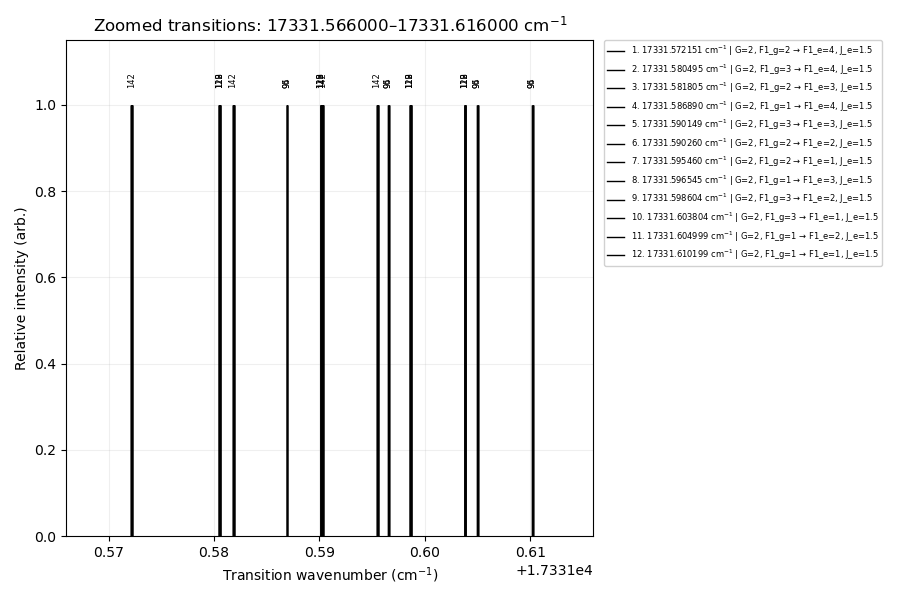

Total allowed transitions: 432


In [92]:
transitions_df = compute_transition_spectrum(
    X010_173,
    All_excited_states_assignments,
    ground_parity_select=1,
    offset_MHz=240, #offset_MHz=119.418*2,
    zoom_min_cm1=17331.566,
    zoom_max_cm1=17331.616,
    show_labels=False,
    label_fontsize=8,
    use_hover=True,
    legend_from_labels=True,
)

In [19]:
%matplotlib widget